# Test Data Trend Analysis

In [1]:
# IMPORTANT: to run any lines of code in this application, please run all lines of code from section 1.1, 
# unless stated otherwise in the block of code

## Installation of Needed Libraries

In [102]:
# If these imports have already been made once, they may be ignored
!pip install pandasql
!pip install plotly==5.14.1
!pip install graphviz

In [1]:
# These imports must be made every time the kernel is launched
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas as pd
from pandasql import sqldf
import plotly.express as px
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

### Defining Necessary Functions

In [2]:
def obtainFullPatientInfo():
    clinicalPatientDF = pd.read_csv("../Test-Data/data_clinical_patient.txt",delimiter="\t", header = 4)
    clinicalSampleDF = pd.read_csv("../Test-Data/data_clinical_sample.txt",delimiter="\t", header = 4)
    
    fullPatientInfo = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])
    
    # The following is necessary to search for the next line, as the .str.contains method will not work when a DF has empty cells
    fullPatientInfo[['MSI_STATUS']] = fullPatientInfo[['MSI_STATUS']].fillna('Unknown')
    fullPatientInfo[['FIRST_SITE_OF_METS']] = fullPatientInfo[['FIRST_SITE_OF_METS']].fillna('Not Provided')
    fullPatientInfo[['METASTATIC_BIOPSY_SITE']] = fullPatientInfo[['METASTATIC_BIOPSY_SITE']].fillna('Not Provided')
    
    return fullPatientInfo

In [3]:
def display_and_visualize_cluster(numClusters):
    # the model is first train based on the input (the desired number of clusters) and data provided
    kmeans = KMeans(n_clusters = numClusters)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    
    # prints all of the points in the dataframe that are not empty
    plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
    
    # prints the clusters on the plot
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    
    
    # the data is exported and tracked back to the original dataset so each datapoint in a cluster can be analyzed
    Y = y_kmeans[:, np.newaxis]
    
    # what first needs to be done is each datapoint in the cluster dataset (index maps to index of X value) 
    # needs to be connected with its corresponding X value, which can be done through a horizontal join 
    combinedArrays = np.hstack((X, Y))
    lastColumnName = 'CLUSTER_NUMBER_' + str(numClusters)
    combinedDF = pd.DataFrame(combinedArrays, columns = ['AGE_AT_DIAGNOSIS','OS_MONTHS', lastColumnName])
    
    # prevents the join function from creating more cells than necessary
    noDups = combinedDF.drop_duplicates()
    
    
    # since an outer join is completed, where duplicate rows would result in a table larger than earlier, we first eliminate duplicates to 
    # preserve the order and size of resultUnchanged 
    new_df = pd.merge(resultUnchanged, noDups,  how='left', left_on=['AGE_AT_DIAGNOSIS','OS_MONTHS'], right_on = ['AGE_AT_DIAGNOSIS','OS_MONTHS'])
    
    return new_df

In [4]:
def group_and_visualize_plots(currentValues):
    grouped = resultUnchanged.groupby(currentValues)
    
    data = []
    value = 0
    
    arrayForm = resultUnchanged[currentValues]
    display(arrayForm)
    
    allCombos = list(arrayForm.groupby(currentValues).groups)
    
    for i in allCombos:
        #temporary = np.array_str(i)
        #temporary = temporary[2:(len(temporary)-2)]
        df = grouped.get_group(i)
        #display(df)
        value += 1
        #df = df[['AGE_AT_DIAGNOSIS', 'OS_MONTHS', 'SEX', "MSI_STATUS", 'VITAL_STATUS']]
    
        fig = px.scatter(df, x="AGE_AT_DIAGNOSIS", y="OS_MONTHS", color = df[currentValues].apply(tuple, axis=1), hover_data=["PATIENT_ID", "SAMPLE_ID"])
        website = 'data' + str(value) + '.html'
        fig.show()

In [5]:
def prepareContainerForAnalysis(containerToModify):
    columnsToRemove = []
    for col in containerToModify.columns:
        if containerToModify[col].dtype == 'float64' or containerToModify[col].dtype == 'int64':
            containerToModify[[col]] = containerToModify[[col]].fillna(0)
        else:
            stringToAdd = 'Not_Provided'
            containerToModify[[col]] = containerToModify[[col]].fillna(stringToAdd)
            oneHotEncodedColumns = pd.get_dummies(containerToModify[col])
            prefixToAdd = col + '_'
            for i in oneHotEncodedColumns.columns:
                newColumnName = prefixToAdd + i
                newColumnName = newColumnName.upper()
                oneHotEncodedColumns.rename(columns = {i:newColumnName}, inplace = True)
            del containerToModify[col]
            containerToModify = pd.concat([containerToModify, oneHotEncodedColumns], axis=1)
    return containerToModify

## Patient Information Dataframes

### Data Processing

In [65]:
#Patient Identifier	Age at Diagnosis	Sex	Patient's Vital Status	Overall Survival Status	Overall Survival (Months)	OS Months (Additonal Data)	Patient Tumor Grade
#Identifier to uniquely specify a patient.	Age at Diagnosis	Sex	The survival state of the person.	Overall patient survival status.	Overall survival in months since initial diagonosis.	OS Months (Additonal Data)	Patient Tumor Grade
#STRING	NUMBER	STRING	STRING	STRING	NUMBER	NUMBER	STRING
#1	1	1	1	9	1	1	1

clinicalPatientDF = pd.read_csv("../Test-Data/data_clinical_patient.txt",delimiter="\t", header = 4)

In [66]:
clinicalPatientDF

PATIENT_ID  AGE_AT_DIAGNOSIS     SEX VITAL_STATUS   OS_STATUS  OS_MONTHS  \
0     P-0000119                67  Female     Deceased  1:DECEASED      27.37   
1     P-0000241                49  Female     Deceased  1:DECEASED      24.00   
2     P-0000493                24    Male     Deceased  1:DECEASED      23.87   
3     P-0000511                39  Female     Deceased  1:DECEASED      23.27   
4     P-0000520                64    Male       Living    0:LIVING      41.50   
...         ...               ...     ...          ...         ...        ...   
1094  P-0014252                59    Male       Living    0:LIVING      55.37   
1095  P-0014258                69    Male     Deceased  1:DECEASED       9.97   
1096  P-0014296                46  Female       Living    0:LIVING      12.07   
1097  P-0014404                62  Female       Living    0:LIVING        NaN   
1098  P-0014415                49    Male       Living    0:LIVING      24.10   

      OS_MONTHS_ADDITIONAL    PATIENT_GRADE  
0                      NaN         Mod_Diff  
1                      NaN  Mod-Poorly-Diff  
2                      NaN              NaN  
3                      NaN      Poorly-Diff  
4                      NaN  Mod-Poorly-Diff  
...                    ...              ...  
1094                   NaN         Mod_Diff  
1095                   NaN  Mod-Poorly-Diff  
1096                   NaN              NaN  
1097                 28.23      Poorly-Diff  
1098                   NaN         Mod_Diff  

[1099 rows x 8 columns]

In [67]:
#Patient Identifier	Sample Identifier	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI Status	Oncotree Code	Sample Type	Primary Tumor Site	Metastatic Biopsy Site	Primary Tumor Location	Gene Panel	Stage At Diagnosis	Molecular Subtype	MSI Score	mCRC Type	Specimen Type	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#Identifier to uniquely specify a patient.	A unique sample identifier.	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI status.	Oncotree Code	The type of sample (i.e., normal, primary, met, recurrence).	Text term to describe the organ sub-division in an individual with cancer.	Metastatic Biopsy Site	Primary Tumor Location	Gene panel.	Stage At Diagnosis	Molecular subtype.	MSI Score	mCRC Type	The broad cancer phenotype and site information values for a sample to be processed.	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites Description	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER	STRING	STRING	STRING	STRING	NUMBER	NUMBER	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER
#1	1	1	1	1	1	9	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1

clinicalSampleDF = pd.read_csv("../Test-Data/data_clinical_sample.txt",delimiter="\t", header = 4)

In [68]:
clinicalSampleDF

PATIENT_ID          SAMPLE_ID CHEMO_EXP_SEQ_SPECIMEN  \
0     P-0000119  P-0000119-T01-IM3                    Yes   
1     P-0000241  P-0000241-T01-IM3                    Yes   
2     P-0000493  P-0000493-T01-IM3                    Yes   
3     P-0000511  P-0000511-T01-IM3                    Yes   
4     P-0000520  P-0000520-T01-IM3                     No   
...         ...                ...                    ...   
1129  P-0014252  P-0014252-T01-IM6                    Yes   
1130  P-0014258  P-0014258-T01-IM6                     No   
1131  P-0014296  P-0014296-T01-IM6                     No   
1132  P-0014404  P-0014404-T01-IM6                     No   
1133  P-0014415  P-0014415-T01-IM6                    Yes   

     TUMOR_SAMPLE_HISTOLOGY MSI_STATUS ONCOTREE_CODE SAMPLE_TYPE  \
0              Conventional        NaN      COADREAD  Metastasis   
1              Conventional        MSS      COADREAD  Metastasis   
2                       NaN        NaN      COADREAD  Metastasis   
3                       PDC        MSS      COADREAD  Metastasis   
4              Conventional        MSS      COADREAD     Primary   
...                     ...        ...           ...         ...   
1129           Conventional        MSS      COADREAD  Metastasis   
1130           Conventional        NaN      COADREAD     Primary   
1131                    NaN        MSS      COADREAD  Metastasis   
1132       Signet_Ring_Cell        MSI      COADREAD     Primary   
1133           Conventional        MSS      COADREAD     Primary   

         PRIMARY_SITE METASTATIC_BIOPSY_SITE PRIMARY_TUMOR_LOCATION  ...  \
0               Cecum                  Ovary                  Right  ...   
1     Ascending Colon             Peritoneum                  Right  ...   
2       Sigmoid Colon                  Liver                   Left  ...   
3       Sigmoid Colon             Chest Wall                   Left  ...   
4               Cecum                    NaN                  Right  ...   
...               ...                    ...                    ...  ...   
1129            Cecum                  Liver                  Right  ...   
1130    Sigmoid Colon                    NaN                   Left  ...   
1131    Sigmoid Colon             Skull base                   Left  ...   
1132     Rectosigmoid                    NaN                   Left  ...   
1133     Rectosigmoid                    NaN                   Left  ...   

     METASTASES_SITE_FIRST_PELVIS METASTASES_SITE_FIRST_BRAIN  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
...                           ...                         ...   
1129                            0                           0   
1130                            0                           0   
1131                            0                           1   
1132                            0                           0   
1133                            0                           0   

     METASTASES_SITE_FIRST_BONE  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   
...                         ...   
1129                          0   
1130                          0   
1131                          0   
1132                          0   
1133                          0   

      METASTASES_SITE_FIRST_PERITONEUM_OMENTUM_ABDOMEN  \
0                                                    1   
1                                                    0   
2                                                    0   
3                                                    1   
4                                                 

In [69]:
resultUnchanged = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])

In [60]:
#Patient Identifier	Sample Identifier	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI Status	Oncotree Code	Sample Type	Primary Tumor Site	Metastatic Biopsy Site	Primary Tumor Location	Gene Panel	Stage At Diagnosis	Molecular Subtype	MSI Score	mCRC Type	Specimen Type	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#Identifier to uniquely specify a patient.	A unique sample identifier.	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI status.	Oncotree Code	The type of sample (i.e., normal, primary, met, recurrence).	Text term to describe the organ sub-division in an individual with cancer.	Metastatic Biopsy Site	Primary Tumor Location	Gene panel.	Stage At Diagnosis	Molecular subtype.	MSI Score	mCRC Type	The broad cancer phenotype and site information values for a sample to be processed.	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites Description	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER	STRING	STRING	STRING	STRING	NUMBER	NUMBER	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER
#1	1	1	1	1	1	9	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1

dataCnaDF = pd.read_csv("../Test-Data/data_cna.txt",delimiter="\t")

In [61]:
dataCnaDF.to_excel(r'dataCnaDF.xlsx', index=False)
dataCnaDF.to_csv(r'dataCnaDF.csv', index=False)

In [37]:
dataCnaDF

Hugo_Symbol  P-0006287-T01-IM5  P-0004652-T01-IM5  P-0002852-T01-IM3  \
0           RB1                  0                  0                  0   
1          MDC1                  0                  0                  0   
2          ARAF                  0                  0                  0   
3         PREX2                  0                  0                  0   
4         SOX17                  0                  0                  0   
..          ...                ...                ...                ...   
469       ERCC2                  0                  0                  0   
470     HIST3H3                  0                  0                  0   
471       ERCC5                  0                  0                  0   
472        KRAS                  0                  0                  0   
473         TEK                  0                  0                  0   

     P-0009139-T01-IM5  P-0006822-T01-IM5  P-0000682-T01-IM3  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
469                  0                  0                  0   
470                  0                  0                  0   
471                  0                  0                  0   
472                  0                  0                  0   
473                  0                  0                  0   

     P-0011110-T01-IM5  P-0010207-T01-IM5  P-0003886-T01-IM5  ...  \
0                    0                  0                  0  ...   
1                    0                  0                  0  ...   
2                    0                  0                  0  ...   
3                    0                  0                  0  ...   
4                    0                  0                  0  ...   
..                 ...                ...                ...  ...   
469                  0                  0                  0  ...   
470                  0                  0                  0  ...   
471                  0                  0                  0  ...   
472                  0                  0                  0  ...   
473                  0                  0                  0  ...   

     P-0008226-T02-IM5  P-0004736-T01-IM5  P-0010425-T01-IM5  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
469                  0                  0                  0   
470                  0                  0                  0   
471                  0                  0                  0   
472                  0                  0                  0   
473                  0                  0                  0   

     P-0012389-T01-IM5  P-0009842-T01-IM5  P-0010966-T01-IM5  \
0                    0                  0                  0   
1                    0                  0                  0   
2                    0                  0                  0   
3                    0                  0                  0   
4                    0                  0                  0   
..                 ...                ...                ...   
469                  0                  0                  0   
470                  0                  0                  0   
471                  0                  0                  0   
472                  0                  0                  0   
473                 

In [38]:
#Patient Identifier	Sample Identifier	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI Status	Oncotree Code	Sample Type	Primary Tumor Site	Metastatic Biopsy Site	Primary Tumor Location	Gene Panel	Stage At Diagnosis	Molecular Subtype	MSI Score	mCRC Type	Specimen Type	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#Identifier to uniquely specify a patient.	A unique sample identifier.	Chemo Exposure of sequenced specimen	Tumor Sample Histology	MSI status.	Oncotree Code	The type of sample (i.e., normal, primary, met, recurrence).	Text term to describe the organ sub-division in an individual with cancer.	Metastatic Biopsy Site	Primary Tumor Location	Gene panel.	Stage At Diagnosis	Molecular subtype.	MSI Score	mCRC Type	The broad cancer phenotype and site information values for a sample to be processed.	Metastasectomy	Metastasectomy Site	TIme to Metastasis Months	Time from Met Dx to Sequencing	First Site of Metastasis	Metastases Site First: Liver	Metastases Site First: Ln	Metastases Site First: Lung	Metastases Site First: Pelvis	Metastases Site First: Brain	Metastases Site First: Bone	Metastases Site First: Peritoneum, omentum, abdomen	Metastases Site First: Gynecological	Other Metastasis Sites Description	Cancer Type	Cancer Type Detailed	Somatic Status	TMB (nonsynonymous)
#STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER	STRING	STRING	STRING	STRING	NUMBER	NUMBER	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	STRING	NUMBER
#1	1	1	1	1	1	9	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1	1

dataGenePanelMatrixDF = pd.read_csv("../Test-Data/data_gene_panel_matrix.txt",delimiter="\t")

In [39]:
dataGenePanelMatrixDF.to_excel(r'dataGenePanelMatrixDF.xlsx', index=False)
dataGenePanelMatrixDF

SAMPLE_ID  mutations structural_variants
0     P-0000119-T01-IM3  IMPACT341           IMPACT341
1     P-0000241-T01-IM3  IMPACT341           IMPACT341
2     P-0000493-T01-IM3  IMPACT341           IMPACT341
3     P-0000511-T01-IM3  IMPACT341           IMPACT341
4     P-0000520-T01-IM3  IMPACT341           IMPACT341
...                 ...        ...                 ...
1129  P-0014252-T01-IM6  IMPACT468           IMPACT468
1130  P-0014258-T01-IM6  IMPACT468           IMPACT468
1131  P-0014296-T01-IM6  IMPACT468           IMPACT468
1132  P-0014404-T01-IM6  IMPACT468           IMPACT468
1133  P-0014415-T01-IM6  IMPACT468           IMPACT468

[1134 rows x 3 columns]

In [41]:
mutationsDF = pd.read_csv("../Test-Data/data_mutations.txt",delimiter="\t")

In [42]:
mutationsDF.to_excel(r'mutationsDF.xlsx', index=False)
mutationsDF.to_csv(r'mutationsDF.csv', index=False)

### Data Manipulation for Transformation

In [70]:
# The below code was added to enable the processing of the data in MySQL, as the Table Import Wizard does not allow for cells with blank values to be imported 
# for any numerical data

resultUnchanged = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])
resultUnchanged[['MSI_STATUS']] = resultUnchanged[['MSI_STATUS']].fillna('Unknown')
resultUnchanged[['FIRST_SITE_OF_METS']] = resultUnchanged[['FIRST_SITE_OF_METS']].fillna('Not Provided')
resultUnchanged[['METASTATIC_BIOPSY_SITE']] = resultUnchanged[['METASTATIC_BIOPSY_SITE']].fillna('Not Provided')

resultUnchanged[['TIME_FROM_MET_DX_SEQUENCING']] = resultUnchanged[['TIME_FROM_MET_DX_SEQUENCING']].fillna(value=-50000)
result = pd.merge(clinicalPatientDF, clinicalSampleDF, how="outer", on=["PATIENT_ID", "PATIENT_ID"])
result[['OS_MONTHS']] = result[['OS_MONTHS']].fillna(value=-50000)
result[['TIME_FROM_MET_DX_SEQUENCING']] = result[['TIME_FROM_MET_DX_SEQUENCING']].fillna(value=-50000)

In [45]:
svDFUnedited = pd.read_csv("../Test-Data/data_sv.txt",delimiter="\t")
svDF = pd.read_csv("../Test-Data/data_sv.txt",delimiter="\t")
svDF[['Site1_Position']] = svDF[['Site1_Position']].fillna(value=-1)
svDF[['Site2_Position']] = svDF[['Site2_Position']].fillna(value=-1)

svDF[['Normal_Read_Count']] = svDF[['Normal_Read_Count']].fillna(value=-1)
svDF[['Normal_Variant_Count']] = svDF[['Normal_Variant_Count']].fillna(value=-1)
svDF[['Normal_Paired_End_Read_Count']] = svDF[['Normal_Paired_End_Read_Count']].fillna(value=-1)
svDF[['Normal_Split_Read_Count']] = svDF[['Normal_Split_Read_Count']].fillna(value=-1)
svDF[['SV_Length']] = svDF[['SV_Length']].fillna(value=-1)
svDF[['SV_VariantId']] = svDF[['SV_VariantId']].fillna(value=-1)
svDF[['SV_Length']] = svDF[['SV_Length']].fillna(value=-1)
svDF[['Tumor_Read_Count']] = svDF[['Tumor_Read_Count']].fillna(value=-1)
svDF[['Tumor_Variant_Count']] = svDF[['Tumor_Variant_Count']].fillna(value=-1)

In [46]:
svDF.to_excel(r'svDF.xlsx', index=False)

In [47]:
#left_aligned_df = svDF.style.set_properties(**{'text-align': 'left'})
#display(left_aligned_df)

In [48]:
svDF.to_csv(r'svDF.csv', index=False)

In [9]:
usableCNAdf = pd.read_csv("dataCnaDFFlipped.csv")

In [10]:
usableCNAdf

Sample_Id  RB1  MDC1  ARAF  PREX2  SOX17  PPP4R2  MYC  AKT2  \
0     P-0006287-T01-IM5    0     0     0      0      0       0    0     0   
1     P-0004652-T01-IM5    0     0     0      0      0       0    0     0   
2     P-0002852-T01-IM3    0     0     0      0      0       0    0     0   
3     P-0009139-T01-IM5    0     0     0      0      0       0    0     0   
4     P-0006822-T01-IM5    0     0     0      0      0       0    0     0   
...                 ...  ...   ...   ...    ...    ...     ...  ...   ...   
1129  P-0010966-T01-IM5    0     0     0      0      0       0    0     0   
1130  P-0009433-T01-IM5    0     0     0      0      0       0    0     0   
1131  P-0006763-T01-IM5    0     0     0      0      0       0    0     0   
1132  P-0000635-T01-IM3    0     0     0      0      0       0    0     0   
1133  P-0001525-T01-IM3    0     0     0      0      0       0    0     0   

      AKT3  ...  TSHR  ERCC3  ERCC4  CARM1  RPS6KB2  ERCC2  HIST3H3  ERCC5  \
0        0  ...     0      0      0      0        0      0        0      0   
1        0  ...     0      0      0      0        0      0        0      0   
2        0  ...     0      0      0      0        0      0        0      0   
3        0  ...     0      0      0      0        0      0        0      0   
4        0  ...     0      0      0      0        0      0        0      0   
...    ...  ...   ...    ...    ...    ...      ...    ...      ...    ...   
1129     0  ...     0      0      0      0        0      0        0      0   
1130     0  ...     0      0      0      0        0      0        0      0   
1131     0  ...     0      0      0      0        0      0        0      0   
1132     0  ...     0      0      0      0        0      0        0      0   
1133     0  ...     0      0      0      0        0      0        0      0   

      KRAS  TEK  
0        0    0  
1        0    0  
2        0    0  
3        0    0  
4        0    0  
...    ...  ...  
1129     0    0  
1130     0    0  
1131     0    0  
1132     0    0  
1133     0    0  

[1134 rows x 475 columns]

## Data Analysis

### Different Means of Visualization

#### Primitive Version (Manually Splitting Data) Using Seaborn

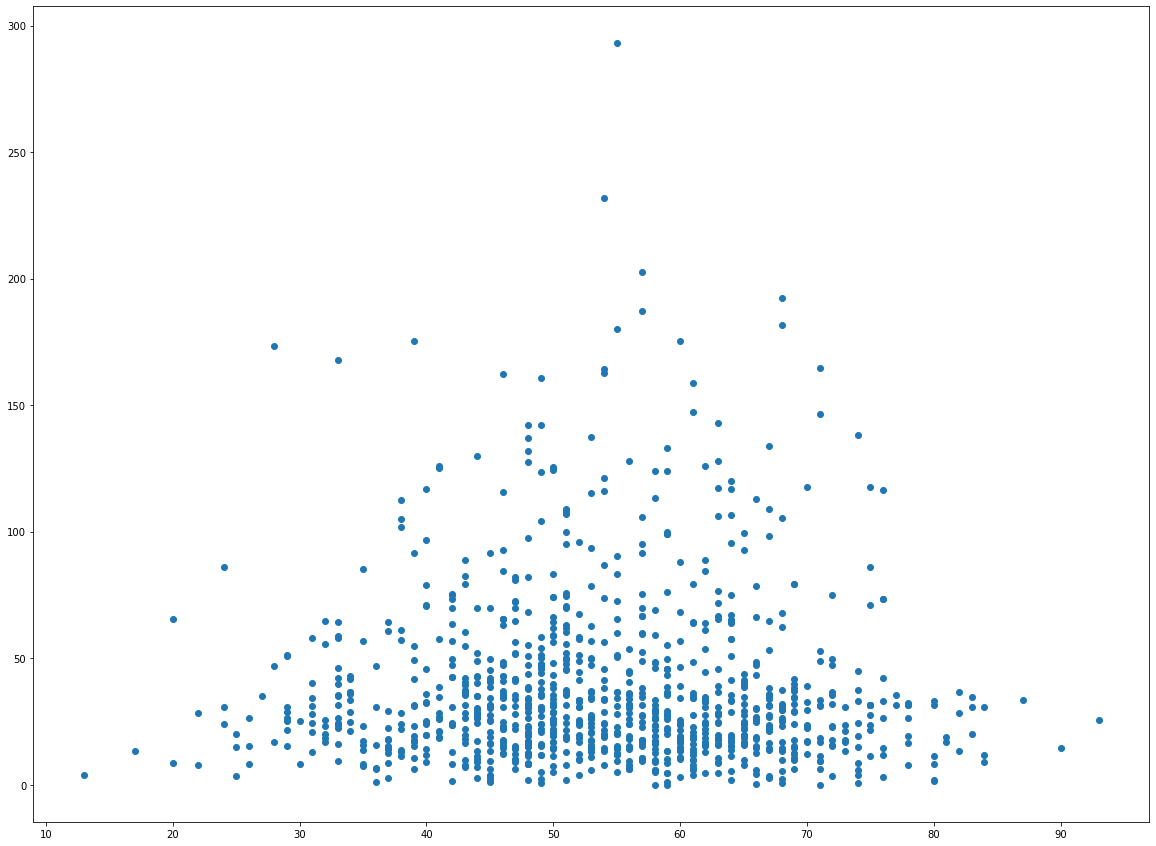

In [73]:
# Split the x and y value to be plotted
xValues = np.array(resultUnchanged['AGE_AT_DIAGNOSIS'])[:, None]
yValues = np.array(resultUnchanged['OS_MONTHS'])
plt.figure(figsize=(20, 15))
plt.scatter(xValues, yValues)

(1134, 41)

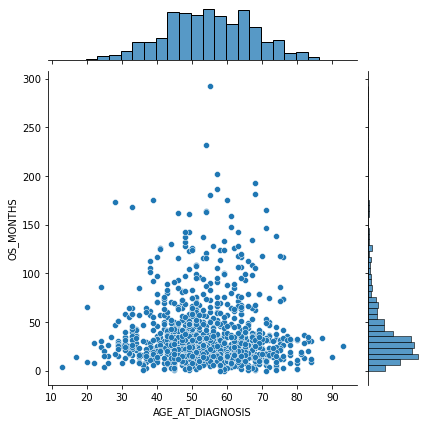

In [76]:
sns.jointplot(x='AGE_AT_DIAGNOSIS', y='OS_MONTHS', data=resultUnchanged)
resultUnchanged.shape

In [ ]:
Males = resultUnchanged[resultUnchanged['SEX'] == 'Male']
Females = resultUnchanged[resultUnchanged['SEX'] == 'Female']

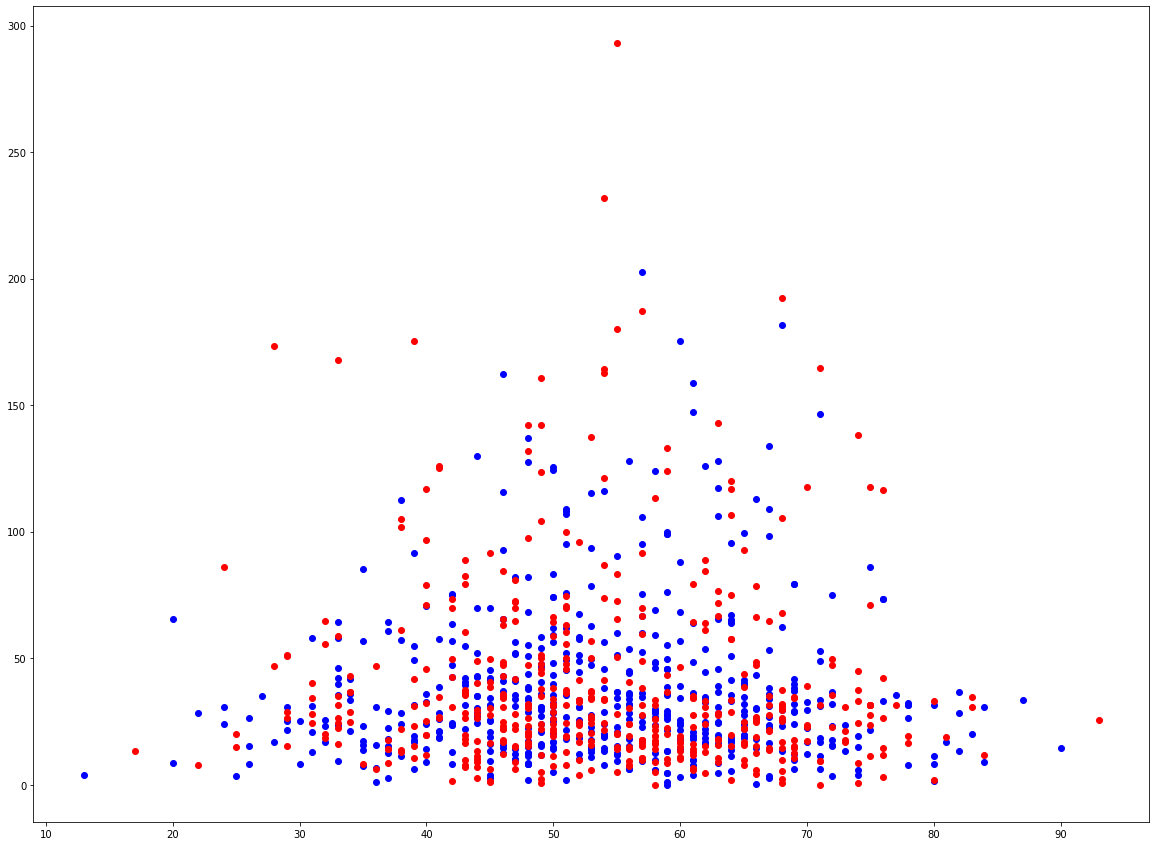

In [33]:
xValuesMales = np.array(Males['AGE_AT_DIAGNOSIS'])[:, None]
yValuesMales = np.array(Males['OS_MONTHS'])

xValuesFemales = np.array(Females['AGE_AT_DIAGNOSIS'])[:, None]
yValuesFemales = np.array(Females['OS_MONTHS'])


plt.figure(figsize=(20, 15))
plt.scatter(xValuesMales, yValuesMales, label = 'Male', color = 'blue')
plt.scatter(xValuesFemales, yValuesFemales, label = 'Female', color = 'red')

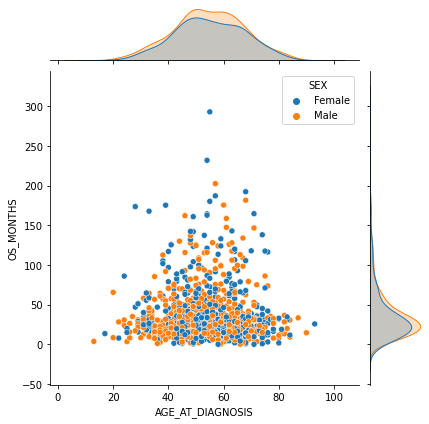

In [78]:
sns.jointplot(x='AGE_AT_DIAGNOSIS', y='OS_MONTHS', hue='SEX', data=resultUnchanged)

#### Advanced Visualization using Plotly

SEX MSI_STATUS
0     Female    Unknown
1     Female        MSS
2       Male    Unknown
3     Female        MSS
4       Male        MSS
...      ...        ...
1129    Male        MSS
1130    Male    Unknown
1131  Female        MSS
1132  Female        MSI
1133    Male        MSS

[1134 rows x 2 columns]

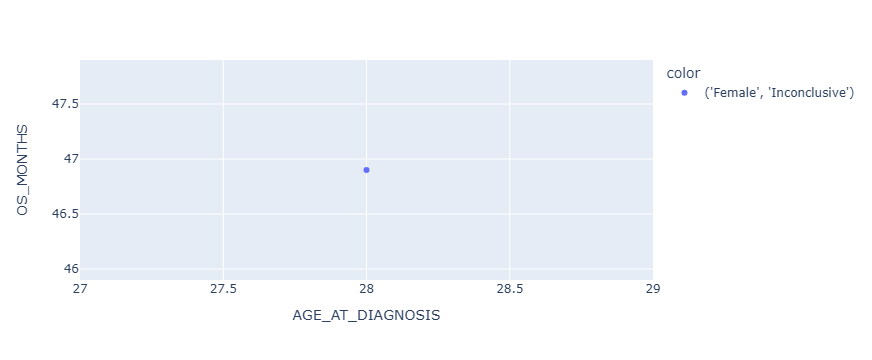

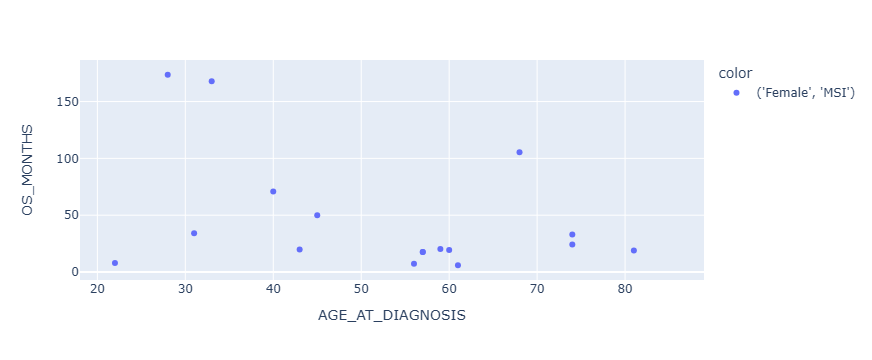

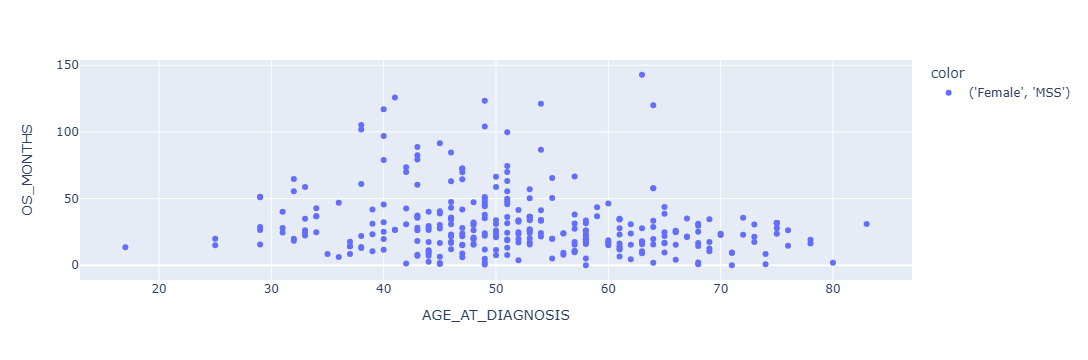

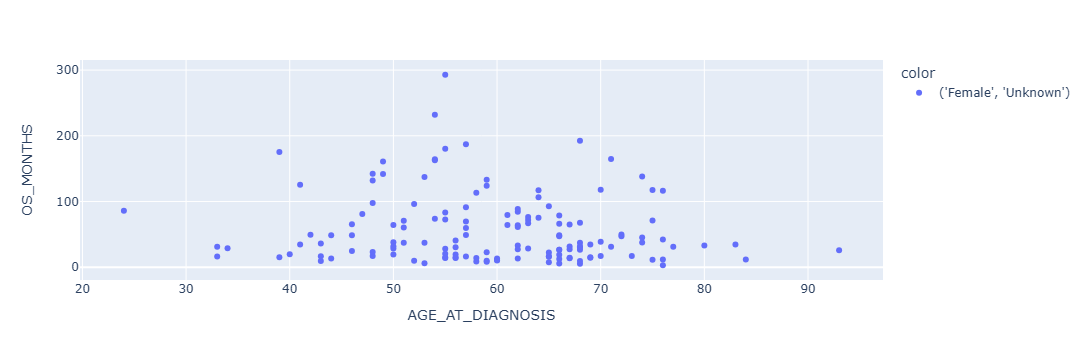

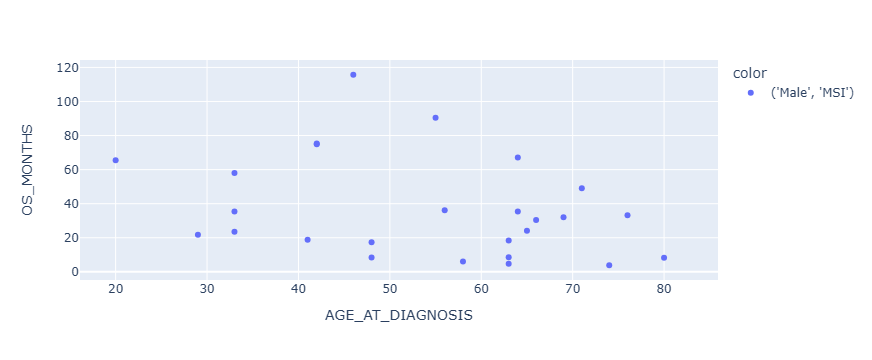

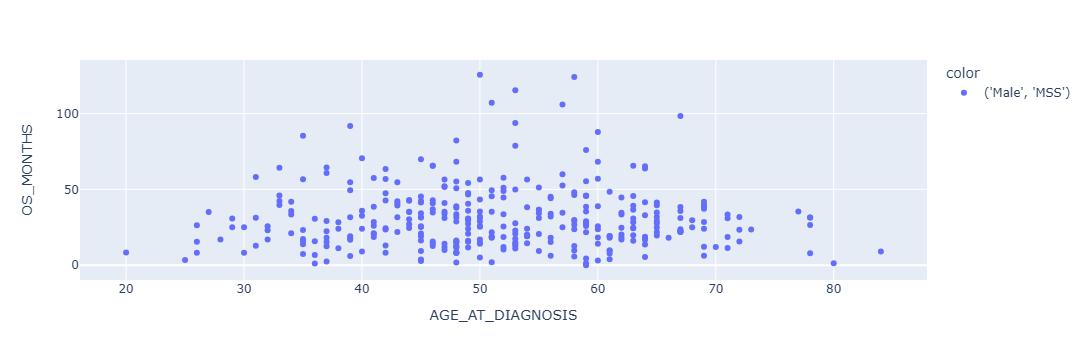

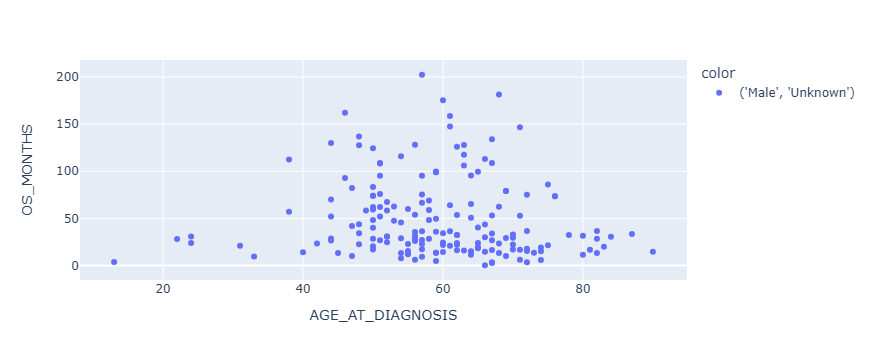

In [92]:
valuesToInsert = ['SEX', "MSI_STATUS"]
group_and_visualize_plots(valuesToInsert)

#### KMeans Clustering Model + Visualization

In [37]:
# preparation of the data for training of the model
xPandas = resultUnchanged[['AGE_AT_DIAGNOSIS','OS_MONTHS']]
xPandas = xPandas.dropna()
X = xPandas.to_numpy()
#display(X)
#print(X.shape)

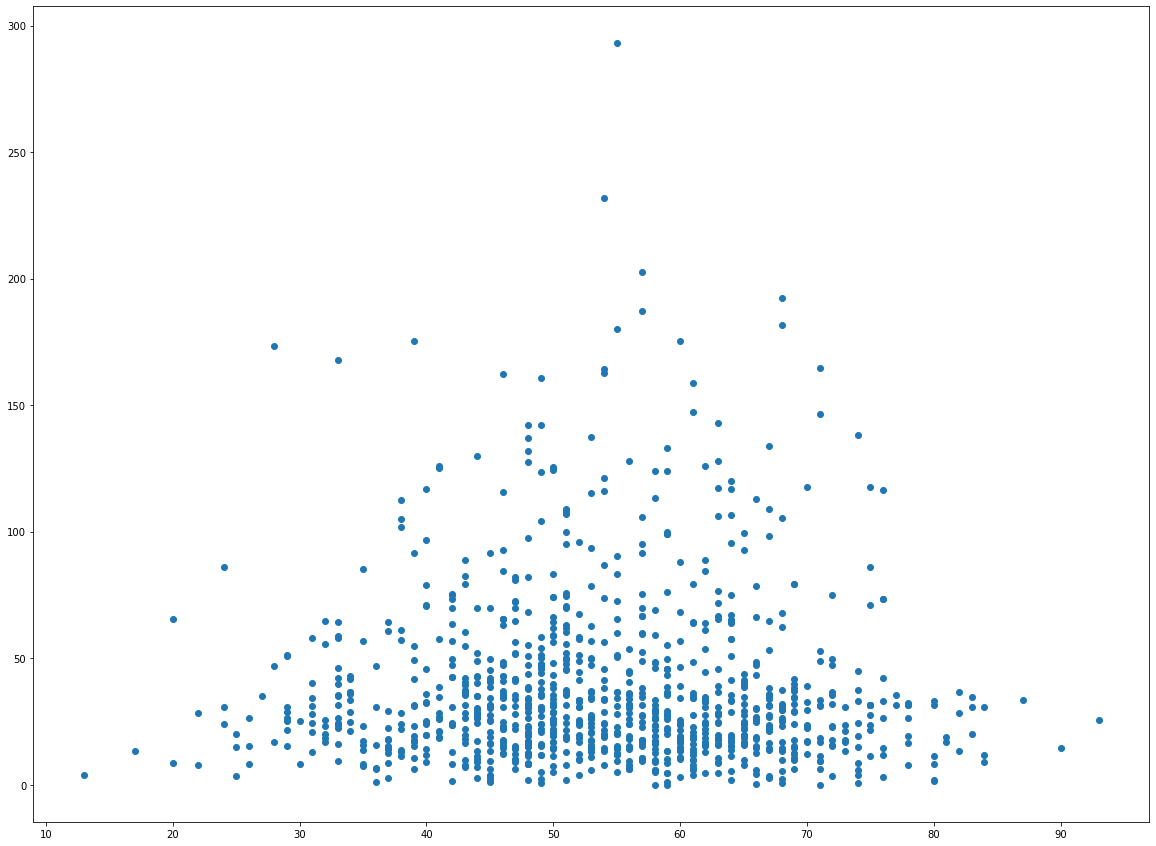

In [38]:
xValues = np.array(resultUnchanged['AGE_AT_DIAGNOSIS'])
yValues = np.array(resultUnchanged['OS_MONTHS'])
plt.figure(figsize=(20, 15))
plt.scatter(xValues, yValues)

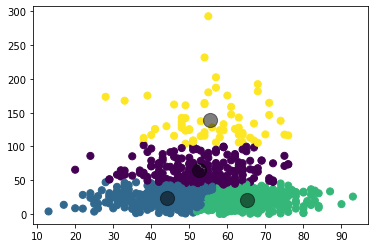

In [42]:
# Function returns a Pandas Dataframe that merges the information from the existing UnchangedData frame and 
# adds the corresponding cluster from the graph for each datapoint, allowing one to then compare similar datapoints
four_clusters = display_and_visualize_cluster(4)

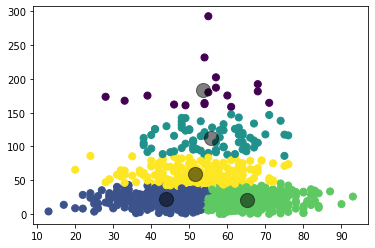

In [41]:
five_clusters = display_and_visualize_cluster(5)

## Liver Metastasis Data Analysis Only

In [13]:
temporaryDF = obtainFullPatientInfo()

liverString = 'Liver'
#liverOnlyFirstSite = temporaryDF.loc[[temporaryDF['FIRST_SITE_OF_METS'].str.contains(liverString)] || [temporaryDF['METASTATIC_BIOPSY_SITE'].str.contains(liverString)]]
liverOnlyFirstSite = temporaryDF.loc[temporaryDF['FIRST_SITE_OF_METS'].str.contains(liverString)]
liverOnlyMBS = temporaryDF.loc[temporaryDF['METASTATIC_BIOPSY_SITE'].str.contains(liverString)]
liverOnly = pd.merge(liverOnlyFirstSite, liverOnlyMBS, how = 'inner')

In [4]:
# Run this line only to export files that contain only liver metastatis patients
liverOnly.to_csv(r'liverMetastasisOnly.csv', index=False)
liverOnly.to_excel(r'liverMetastasisOnly.xlsx', index=False)

<AxesSubplot:>

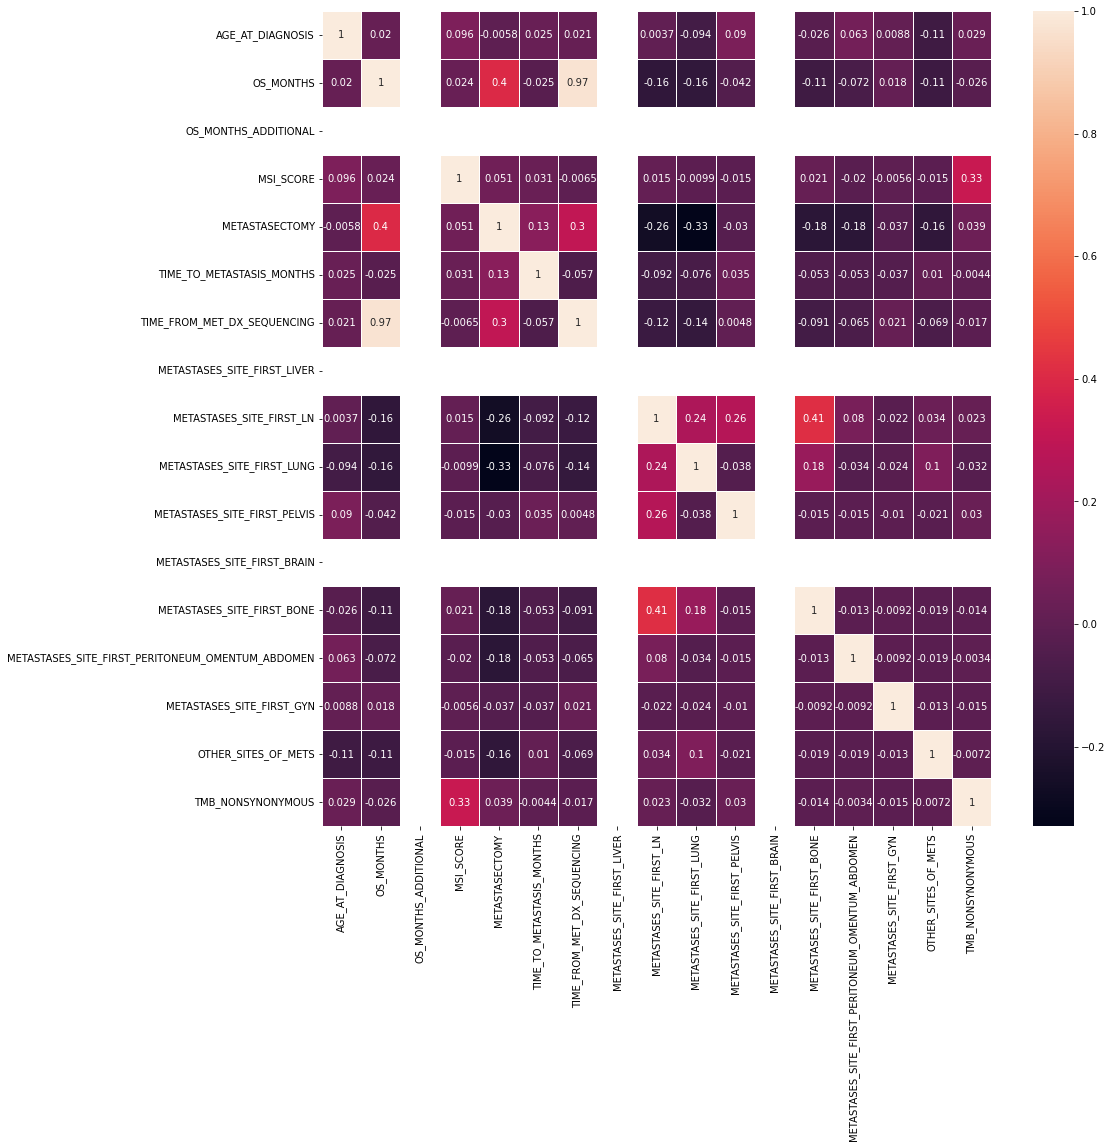

In [60]:
# Visual representation of the correlation between the variables
corr = liverOnly.corr()

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

OS_MONTHS TIME_FROM_MET_DX_SEQUENCING
0.9721430447713816



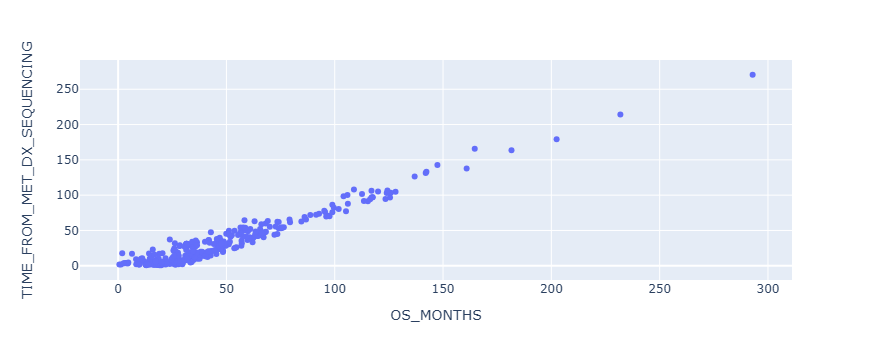

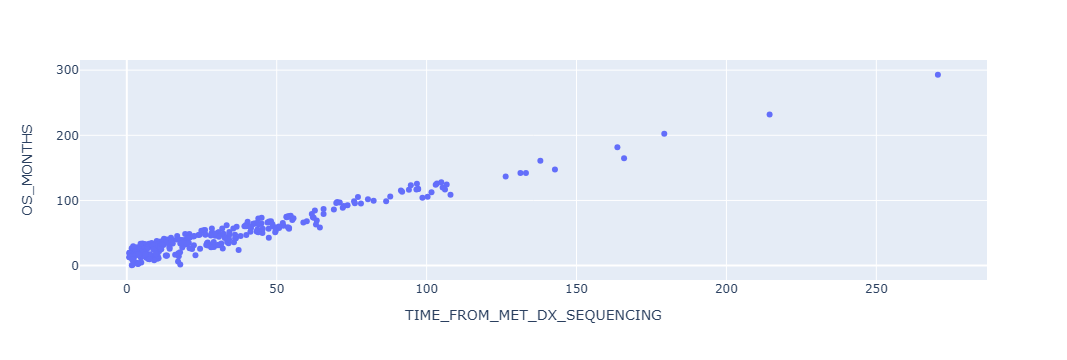

MSI_SCORE TMB_NONSYNONYMOUS
0.32534256068336437



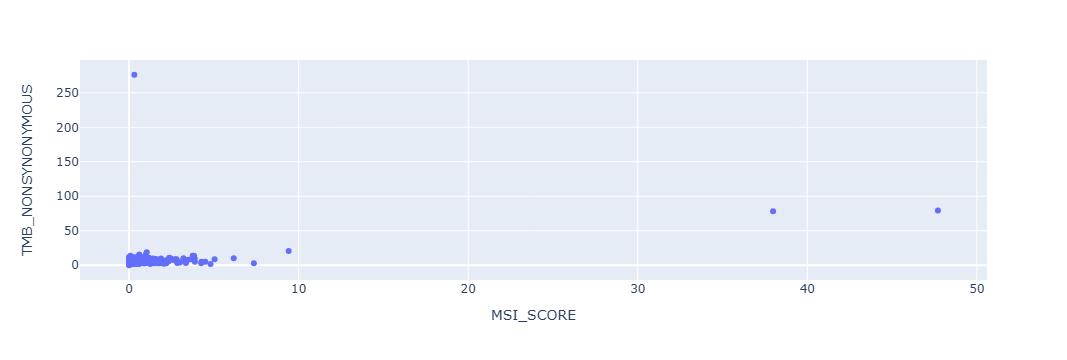

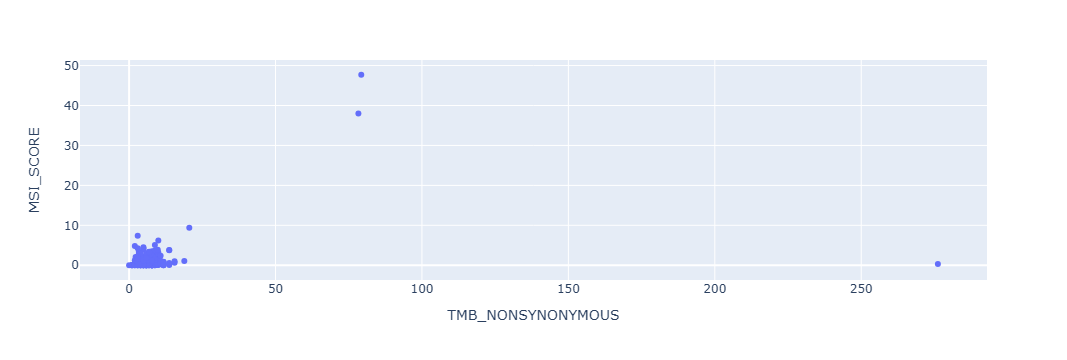

METASTASECTOMY OS_MONTHS
0.40193484976687144



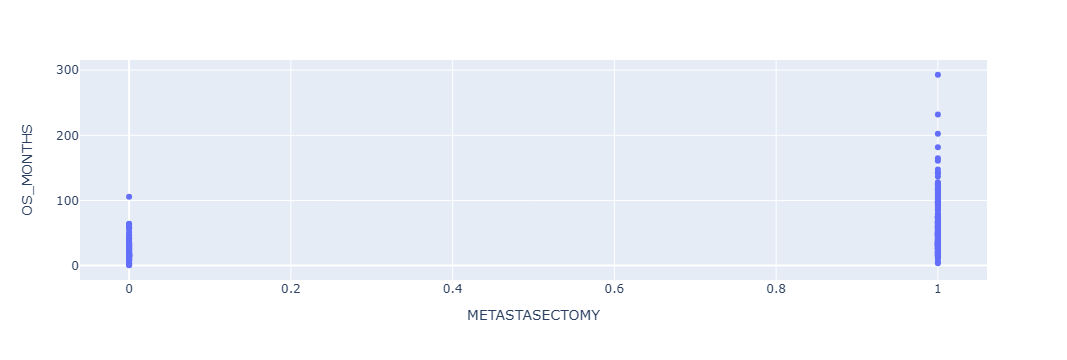

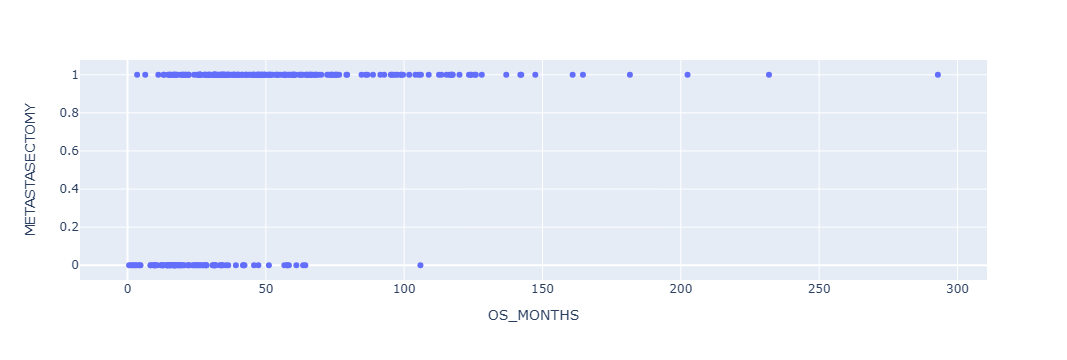

METASTASECTOMY TIME_FROM_MET_DX_SEQUENCING
0.30245181498646084



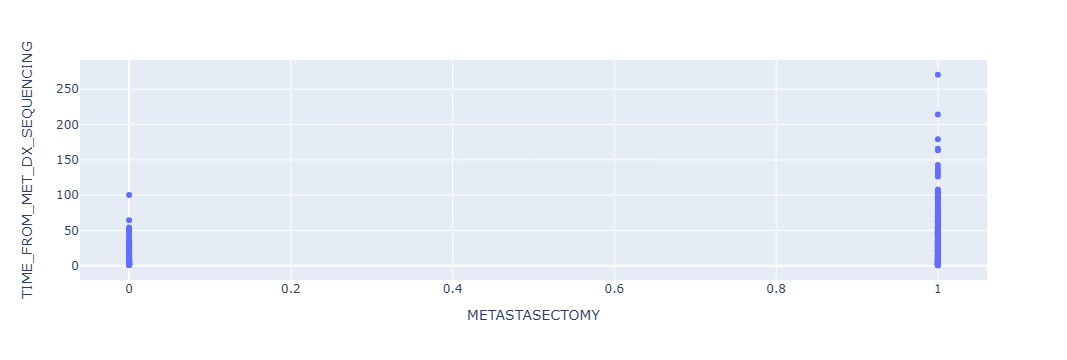

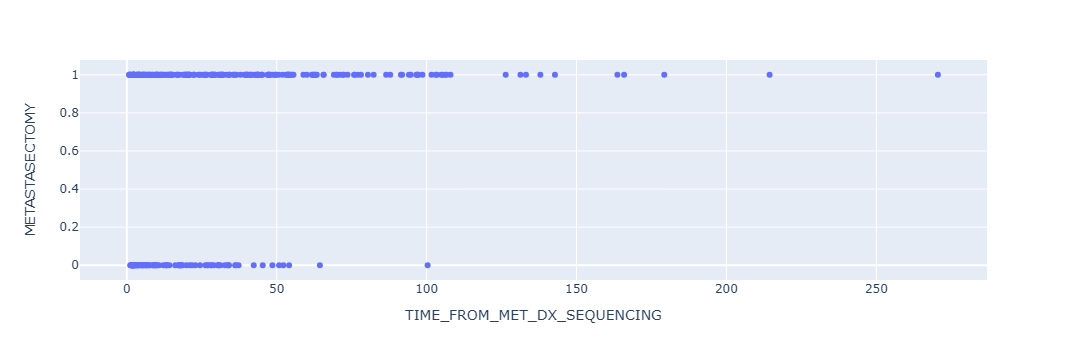

METASTASES_SITE_FIRST_LN METASTASES_SITE_FIRST_LUNG
0.24130941691402347



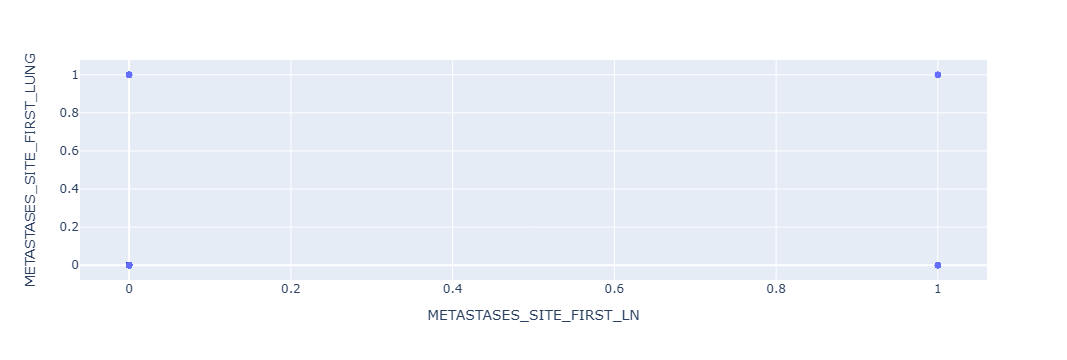

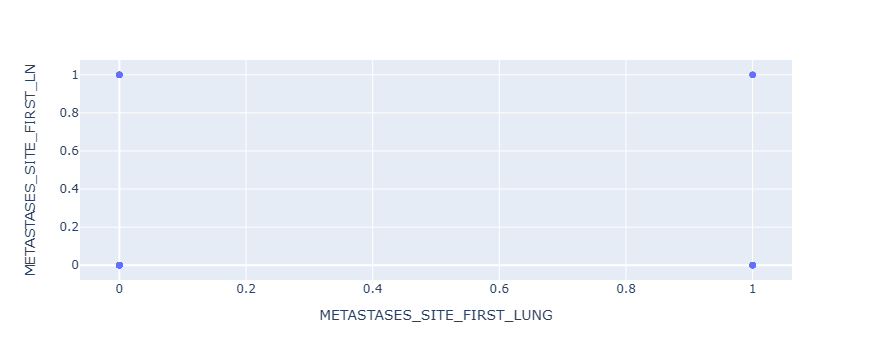

METASTASES_SITE_FIRST_LN METASTASES_SITE_FIRST_PELVIS
0.26387233370492247



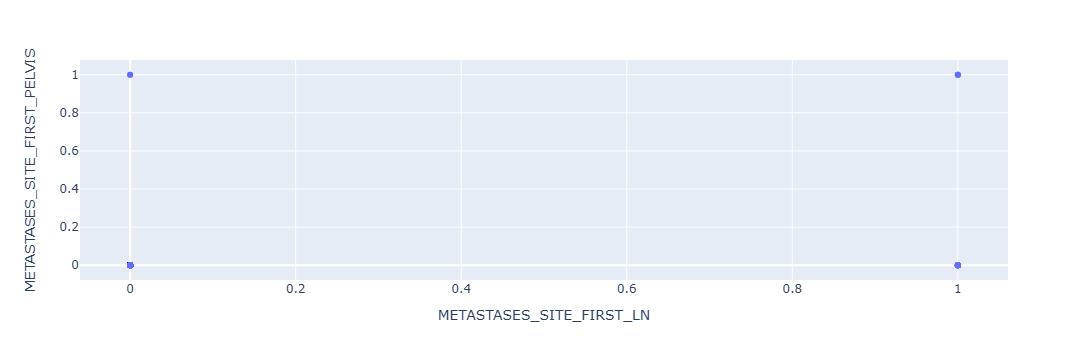

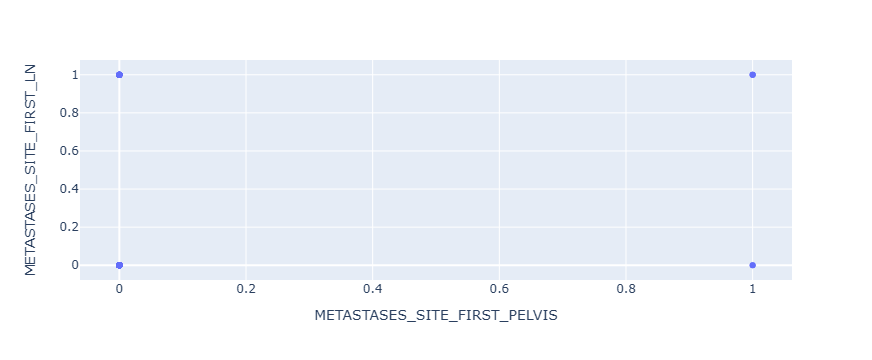

METASTASES_SITE_FIRST_BONE METASTASES_SITE_FIRST_LN
0.41371225797118616



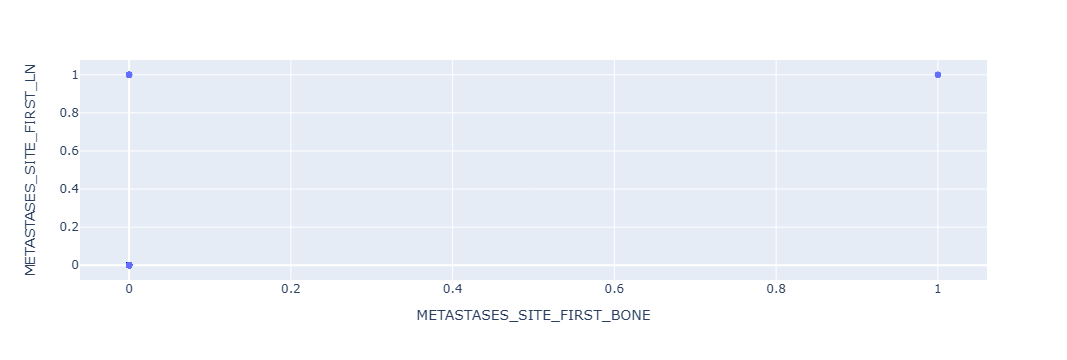

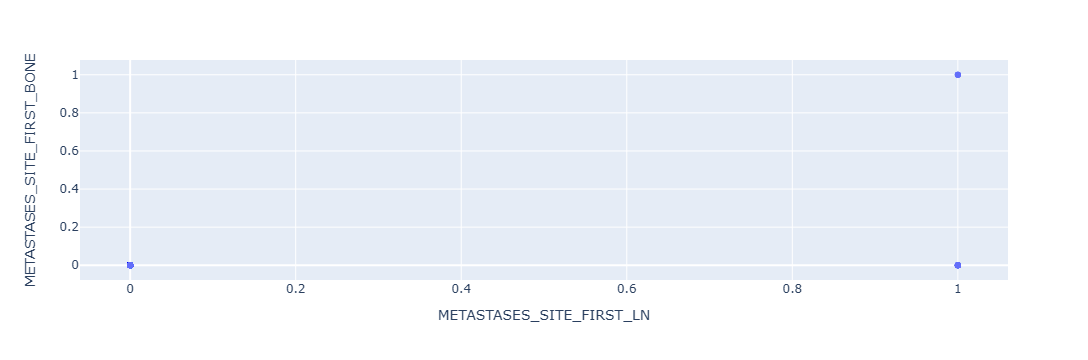

In [97]:
# The following block of code is used to iterate over the Pandas Dataframe containing the correlations between the variables

relevantColumns = set()

for rowIndex, row in corr.iterrows(): 
    #iterates over rows
    for columnIndex, value in row.items():
    # iterates over columns
        # the value of 0.2 was picked arbitrarily, if higher values of correlation are required, then the below line can be adjusted
        if (value > 0.2) and (rowIndex < columnIndex):
            # for values that show some degree of correlation, their values are printed and the graphs are 
            # visualized to graphically show the relationships between the two variables
            relevantColumns.add(rowIndex)
            relevantColumns.add(columnIndex)
            print(rowIndex, columnIndex)
            print(value)
            print()
            fig = px.scatter(liverOnly, x=rowIndex, y=columnIndex, hover_data=["PATIENT_ID", "SAMPLE_ID"])
            fig.show()
            fig = px.scatter(liverOnly, x=columnIndex, y=rowIndex, hover_data=["PATIENT_ID", "SAMPLE_ID"])
            fig.show()

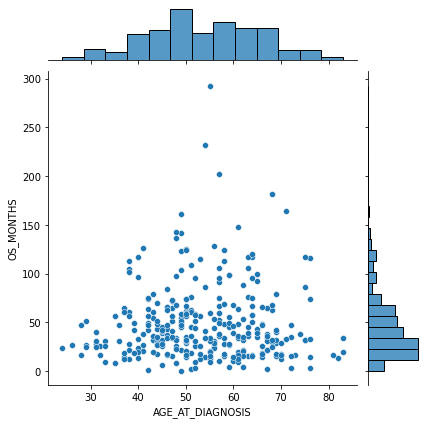

In [63]:
sns.jointplot(x='AGE_AT_DIAGNOSIS', y='OS_MONTHS', data=liverOnly)

In [83]:
listRelevantLiverColumns = []
for i in relevantColumns:
    listRelevantLiverColumns.append(i)

In [89]:
subsetLiver = liverOnly[liverOnly.columns[liverOnly.columns.isin(listRelevantLiverColumns)]]

In [90]:
subsetLiver

OS_MONTHS  MSI_SCORE  METASTASECTOMY  TIME_FROM_MET_DX_SEQUENCING  \
0        23.87        NaN               0                    37.300000   
1        16.00       0.37               0                    22.900000   
2        48.50       0.89               1                    20.866667   
3        54.17       0.27               1                    25.633333   
4        73.53       2.64               1                    44.966667   
..         ...        ...             ...                          ...   
306      17.30       1.22               1                     6.166667   
307      14.03       1.65               0                     1.433333   
308       9.83       0.00               0                     1.800000   
309      25.83       1.82               1                    14.300000   
310      55.37       0.19               1                    43.566667   

     METASTASES_SITE_FIRST_LN  METASTASES_SITE_FIRST_LUNG  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           1                           1   
..                        ...                         ...   
306                         0                           0   
307                         0                           0   
308                         0                           1   
309                         0                           0   
310                         0                           0   

     METASTASES_SITE_FIRST_PELVIS  METASTASES_SITE_FIRST_BONE  \
0                               0                           0   
1                               0                           0   
2                               0                           0   
3                               0                           0   
4                               0                           0   
..                            ...                         ...   
306                             0                           0   
307                             0                           0   
308                             0                           0   
309                             0                           0   
310                             0                           0   

     TMB_NONSYNONYMOUS  
0             4.436621  
1             6.654932  
2             8.873242  
3             6.654932  
4             7.764087  
..                 ...  
306           7.829758  
307           2.936159  
308          11.744636  
309           5.872318  
310           3.458792  

[311 rows x 9 columns]

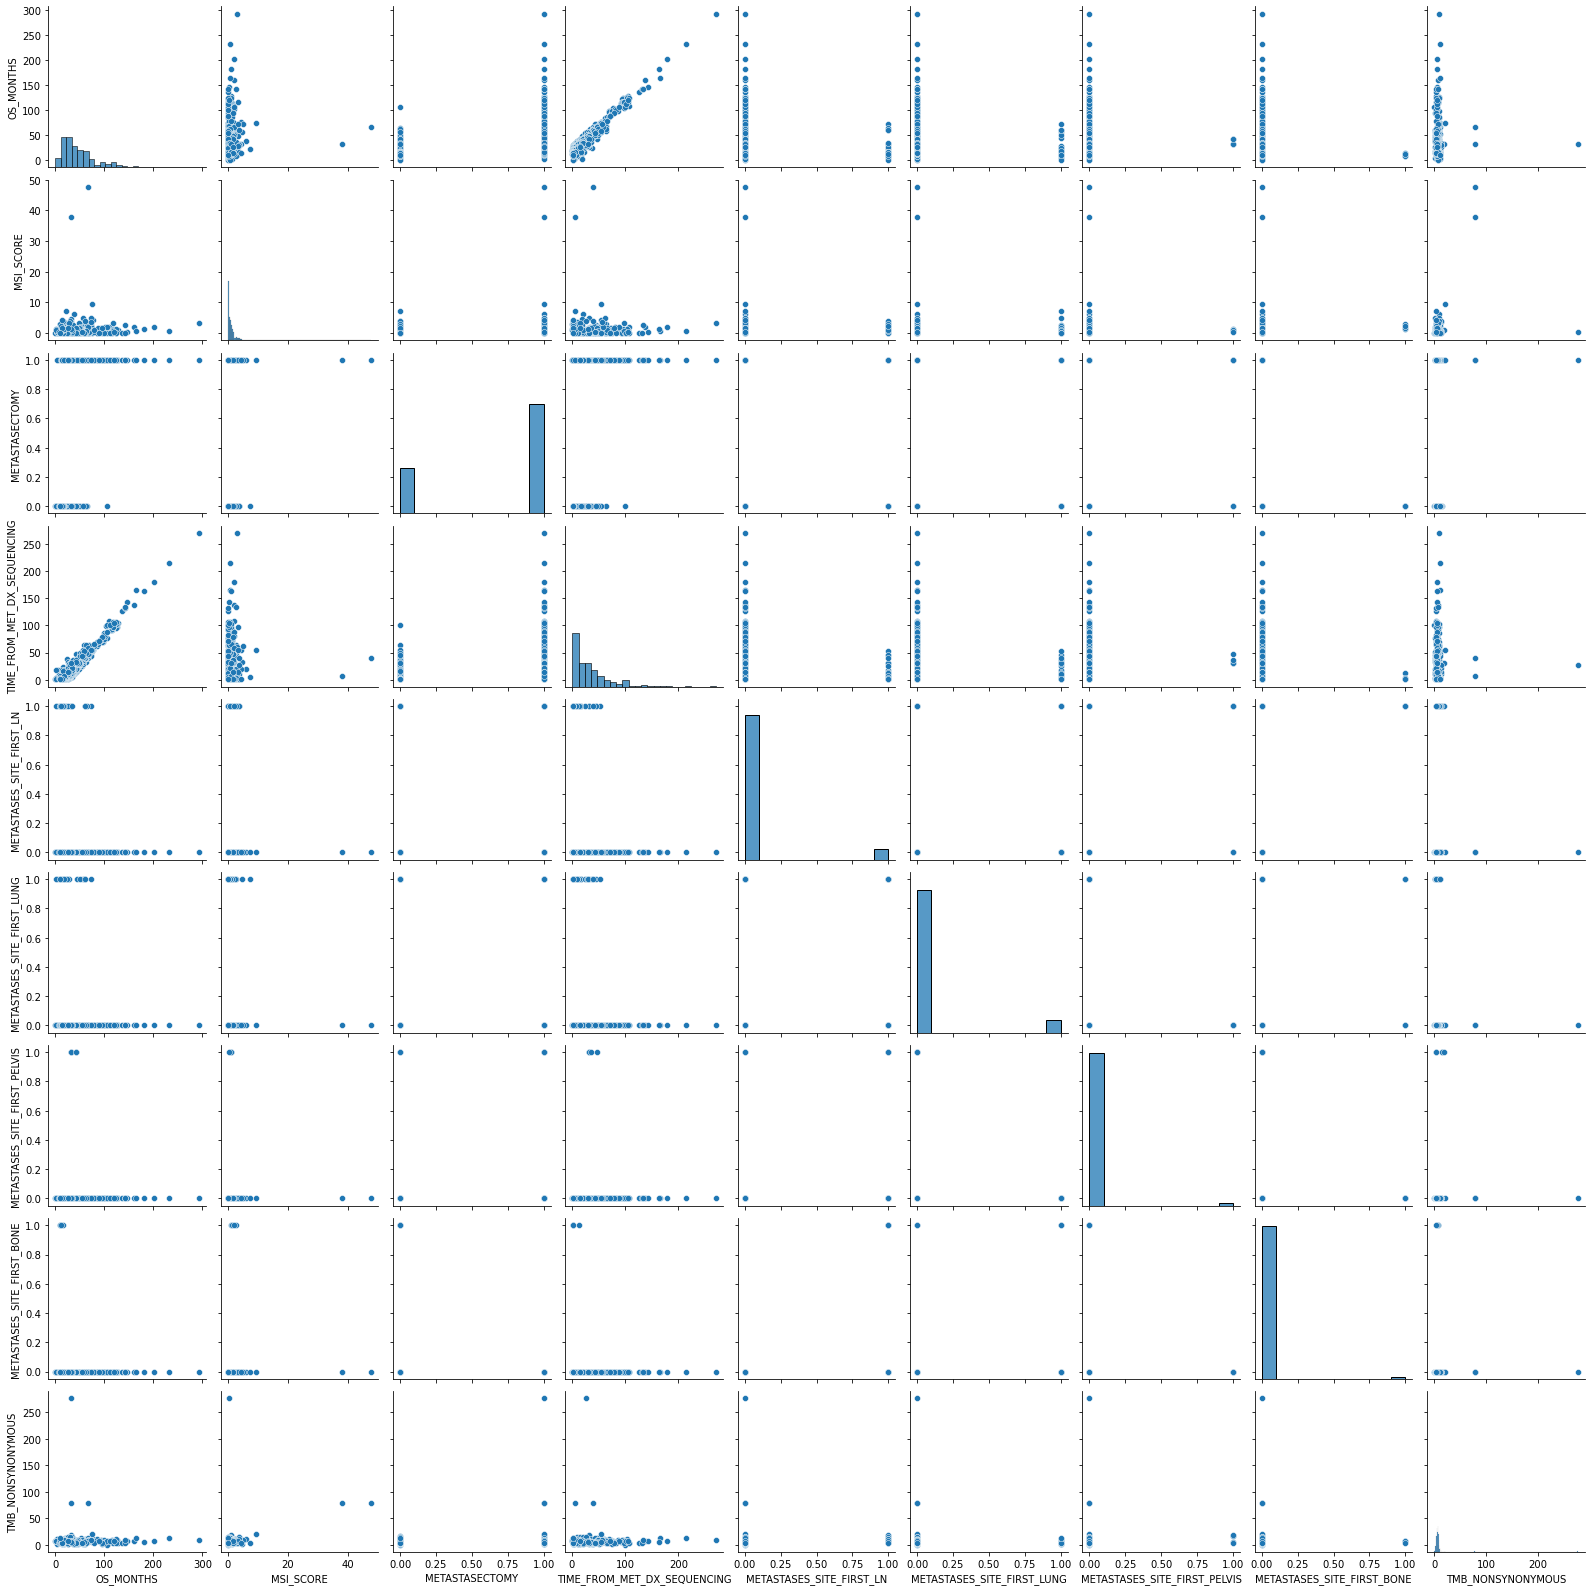

In [91]:
sns.pairplot(subsetLiver, height=2.5)

### Random Forest Models

#### Random Forest with OS_Months as Dependent Variable

In [14]:
temporaryDF = obtainFullPatientInfo()

liverString = 'Liver'
#liverOnlyFirstSite = temporaryDF.loc[[temporaryDF['FIRST_SITE_OF_METS'].str.contains(liverString)] || [temporaryDF['METASTATIC_BIOPSY_SITE'].str.contains(liverString)]]
liverOnlyFirstSite = temporaryDF.loc[temporaryDF['FIRST_SITE_OF_METS'].str.contains(liverString)]
liverOnlyMBS = temporaryDF.loc[temporaryDF['METASTATIC_BIOPSY_SITE'].str.contains(liverString)]
liverOnly = pd.merge(liverOnlyFirstSite, liverOnlyMBS, how = 'inner')

In [15]:
xPandasLiver = liverOnly.drop(['OS_MONTHS', 'OS_MONTHS_ADDITIONAL', 'PATIENT_ID', 'OS_STATUS', 'SAMPLE_ID'], axis=1)
yPandasLiver = liverOnly['OS_MONTHS']

In [16]:
xPandasLiver = prepareContainerForAnalysis(xPandasLiver)

In [17]:
xPandasLiver

AGE_AT_DIAGNOSIS  MSI_SCORE  METASTASECTOMY  TIME_TO_METASTASIS_MONTHS  \
0                  24       0.00               0                   0.000000   
1                  63       0.37               0                   0.000000   
2                  66       0.89               1                   0.000000   
3                  49       0.27               1                   0.000000   
4                  76       2.64               1                   0.000000   
..                ...        ...             ...                        ...   
306                53       1.22               1                   0.000000   
307                40       1.65               0                   0.066667   
308                52       0.00               0                   0.000000   
309                53       1.82               1                   0.000000   
310                59       0.19               1                  19.866667   

     TIME_FROM_MET_DX_SEQUENCING  METASTASES_SITE_FIRST_LIVER  \
0                      37.300000                            1   
1                      22.900000                            1   
2                      20.866667                            1   
3                      25.633333                            1   
4                      44.966667                            1   
..                           ...                          ...   
306                     6.166667                            1   
307                     1.433333                            1   
308                     1.800000                            1   
309                    14.300000                            1   
310                    43.566667                            1   

     METASTASES_SITE_FIRST_LN  METASTASES_SITE_FIRST_LUNG  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           1                           1   
..                        ...                         ...   
306                         0                           0   
307                         0                           0   
308                         0                           1   
309                         0                           0   
310                         0                           0   

     METASTASES_SITE_FIRST_PELVIS  METASTASES_SITE_FIRST_BRAIN  ...  \
0                               0                            0  ...   
1                               0                            0  ...   
2                               0                            0  ...   
3                               0                            0  ...   
4                               0                            0  ...   
..                            ...                          ...  ...   
306                             0                            0  ...   
307                             0                            0  ...   
308                             0                            0  ...   
309                             0                            0  ...   
310                             0                            0  ...   

     FIRST_SITE_OF_METS_LIVER, LYMPH NODES, PSOAS  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
..                                            ...   
306                                             0   
307                                             0   
308                                             0   
309                                             0   
310                                             0   

     FIRST_SITE_OF_METS_LIVER, OVARY  FIRST_SITE_OF_

In [18]:
xPandasLiver.to_csv(r'X_train_data.csv', index=False)

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(xPandasLiver, yPandasLiver, test_size=0.2)

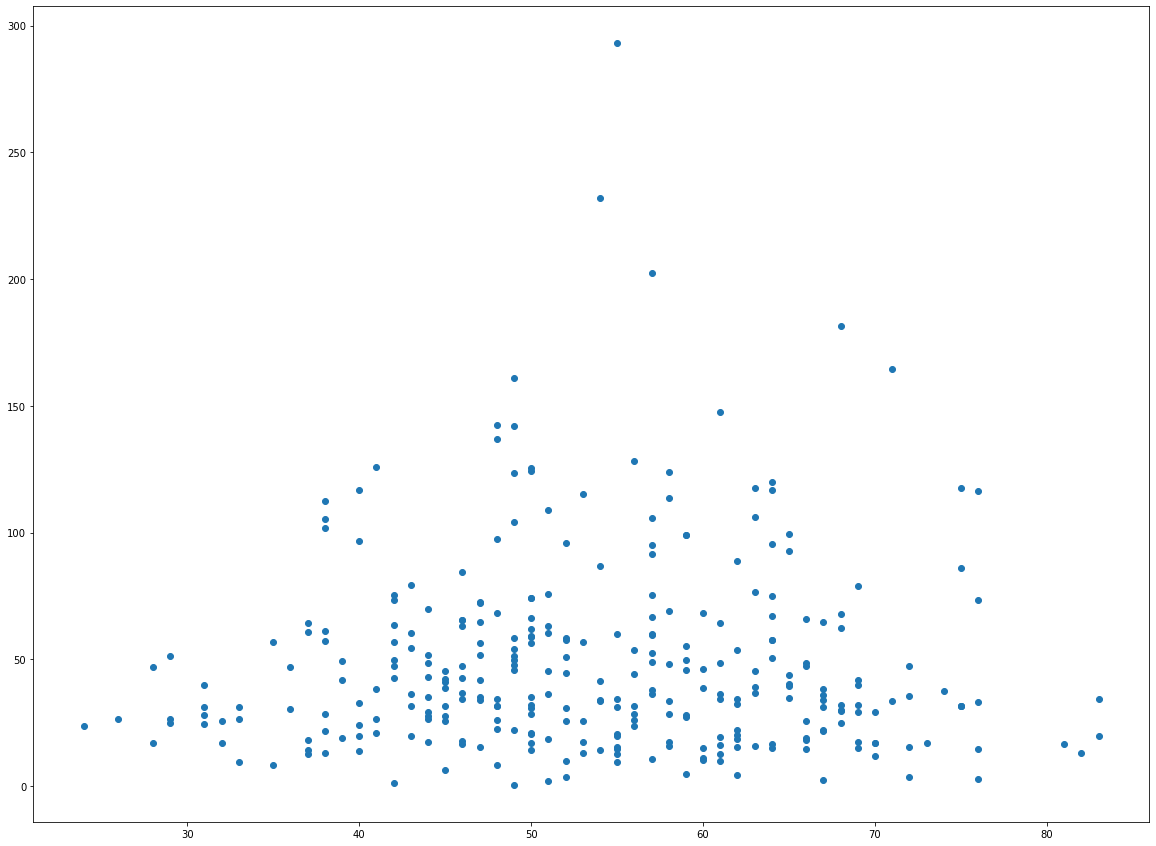

In [14]:
xValues = np.array(liverOnly['AGE_AT_DIAGNOSIS'])
yValues = np.array(liverOnly['OS_MONTHS'])
plt.figure(figsize=(20, 15))
plt.scatter(xValues, yValues)

In [15]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

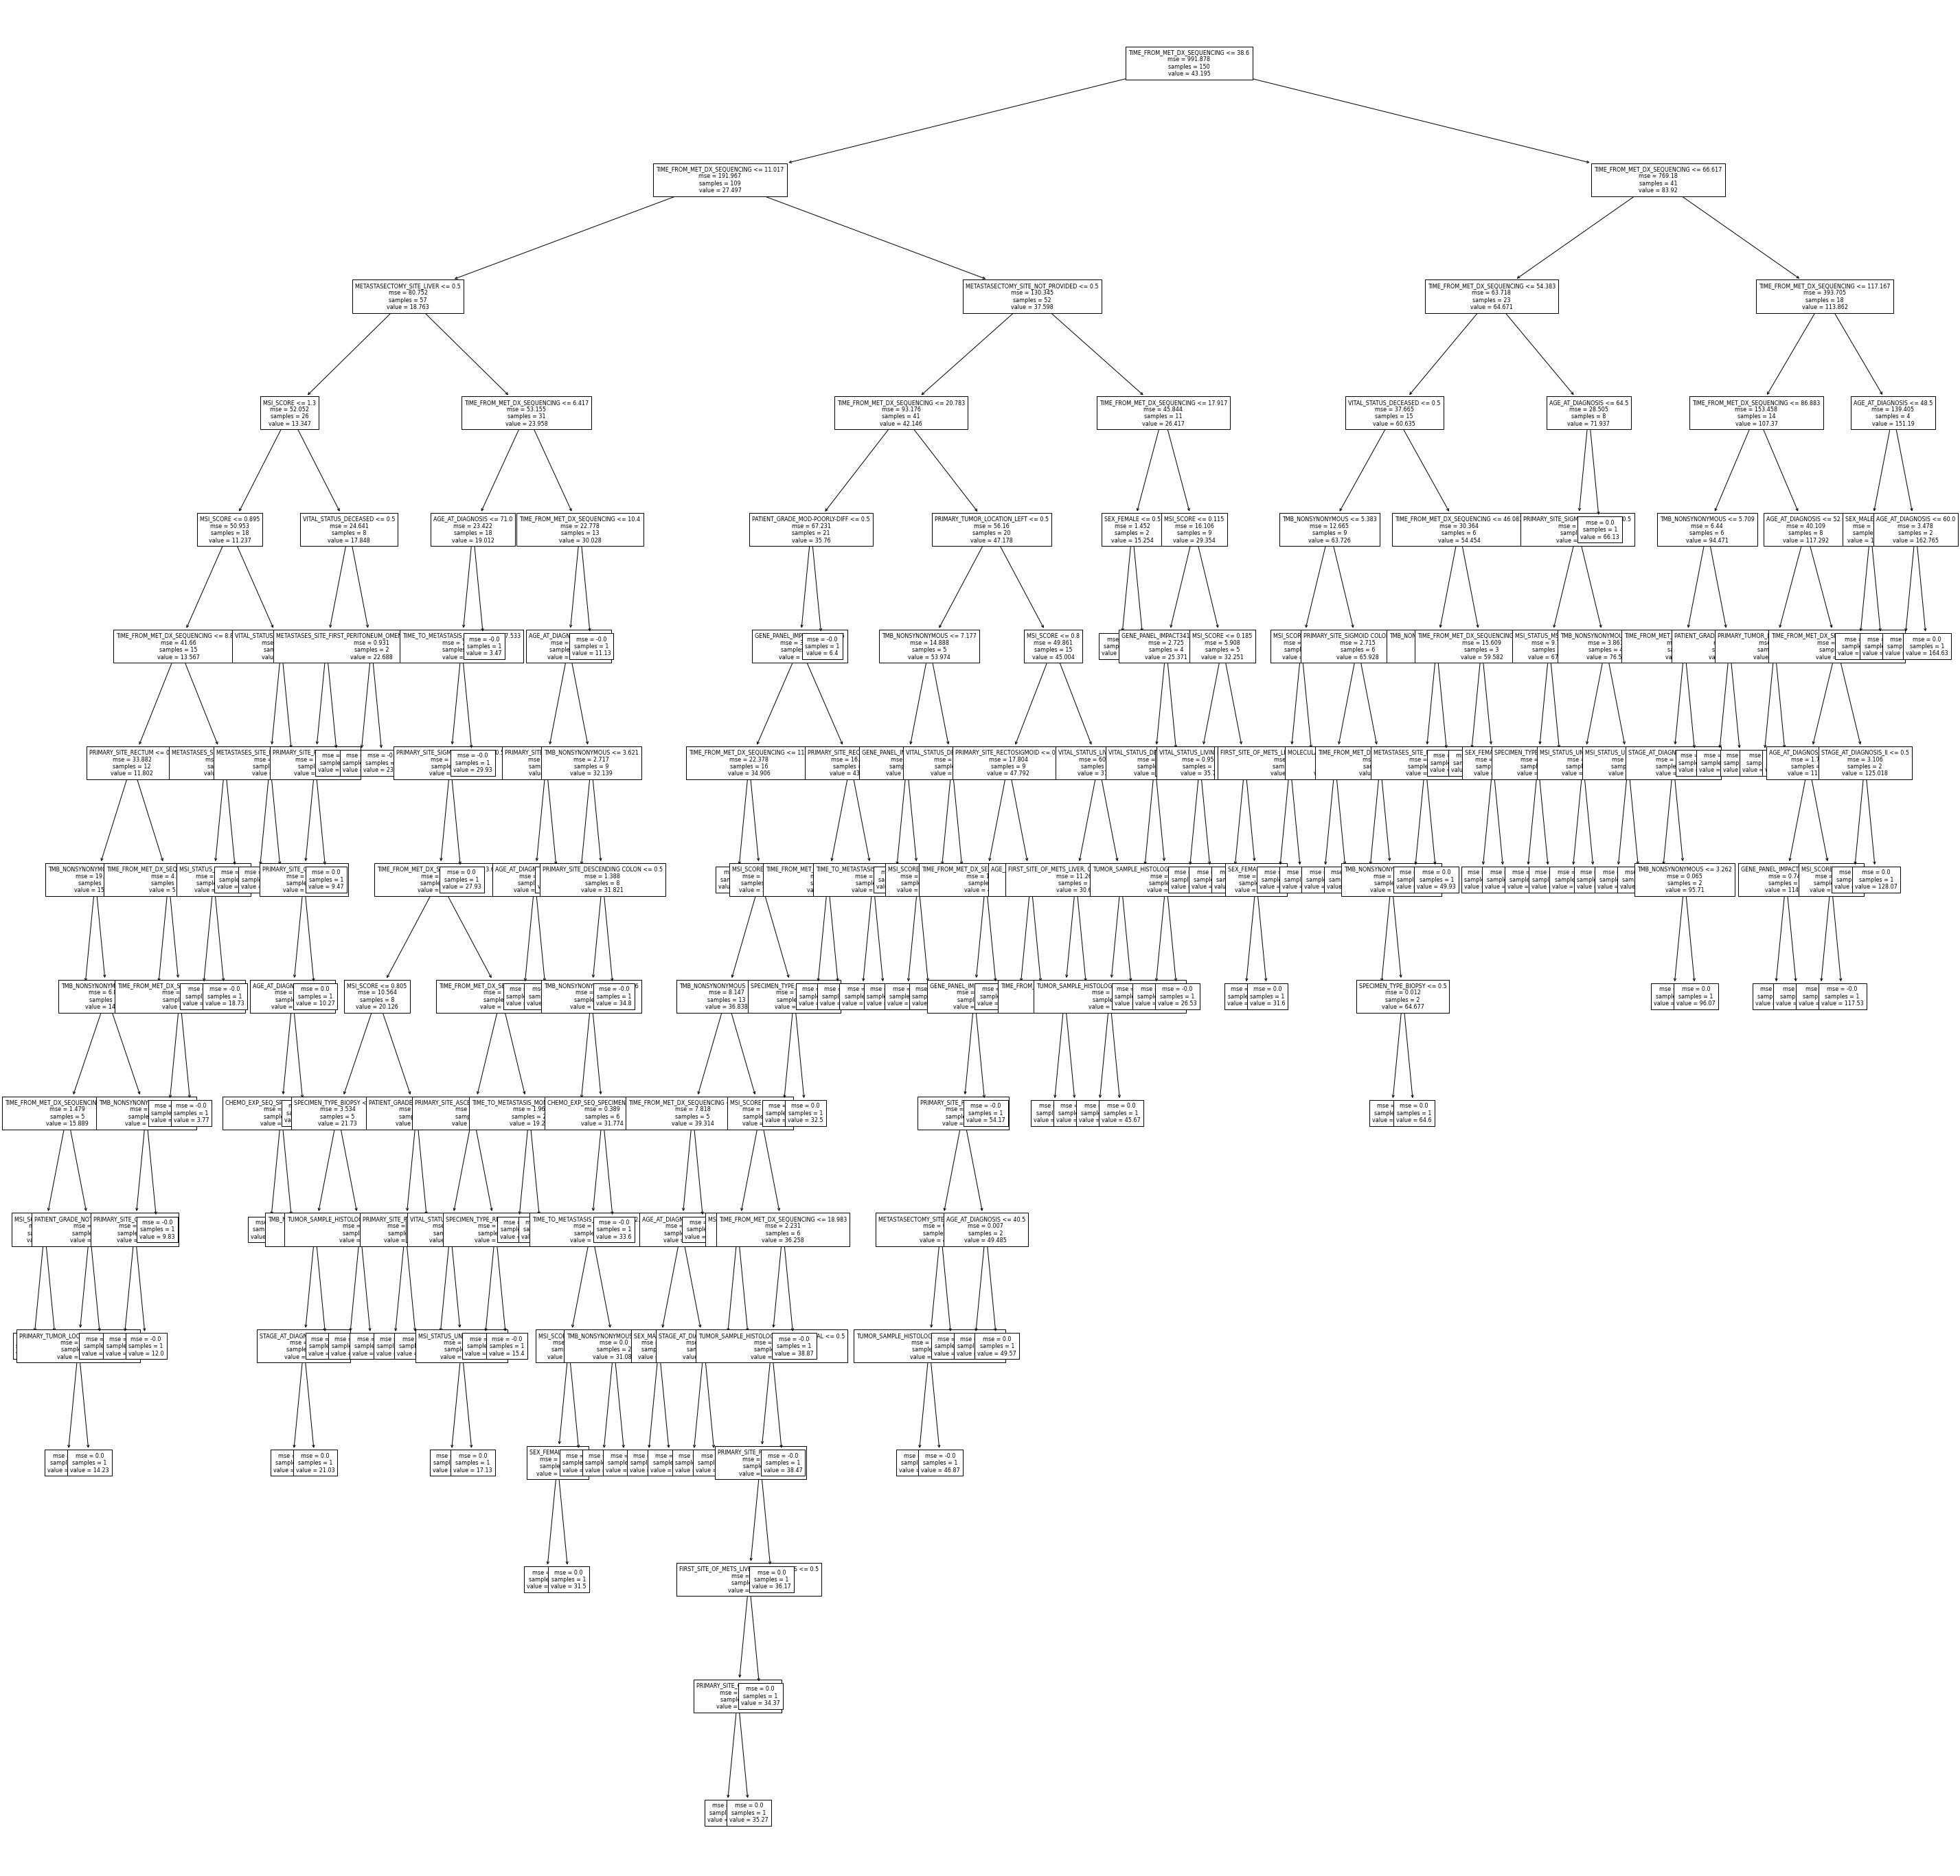

In [42]:
from sklearn import tree
plt.figure(figsize=(50,50))  # set plot size (denoted in inches)
tree.plot_tree(rfr.estimators_[0], feature_names=X_train.columns, fontsize=8)
plt.show()

#### Random Forest with Vital Status as Dependent Variable

In [35]:
xPandasLiverVersion2 = liverOnly.drop(['VITAL_STATUS', 'OS_MONTHS_ADDITIONAL', 'PATIENT_ID', 'OS_STATUS', 'SAMPLE_ID'], axis=1)
yPandasLiverVersion2 = liverOnly['VITAL_STATUS']

In [36]:
xPandasLiverVersion2 = prepareContainerForAnalysis(xPandasLiverVersion2)

In [37]:
currentMap2 = {}
uniqueYValues = np.sort(yPandasLiverVersion2.unique())
for i in range(len(uniqueYValues)):
    currentMap2[uniqueYValues[i]] = i
yPandasLiverVersion2 = yPandasLiverVersion2.map(currentMap2)

In [26]:
yPandasLiverVersion2.to_csv(r'yPandasLiverVersion2.csv', index=False)

In [38]:
# Split the data into training and test sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(xPandasLiverVersion2, yPandasLiverVersion2, test_size=0.2)

In [39]:
#X_train2.shape
y_train2.shape

(248,)

In [40]:
clf = RandomForestClassifier()
clf.fit(X_train2, y_train2)

y_pred2 = clf.predict(X_test2)

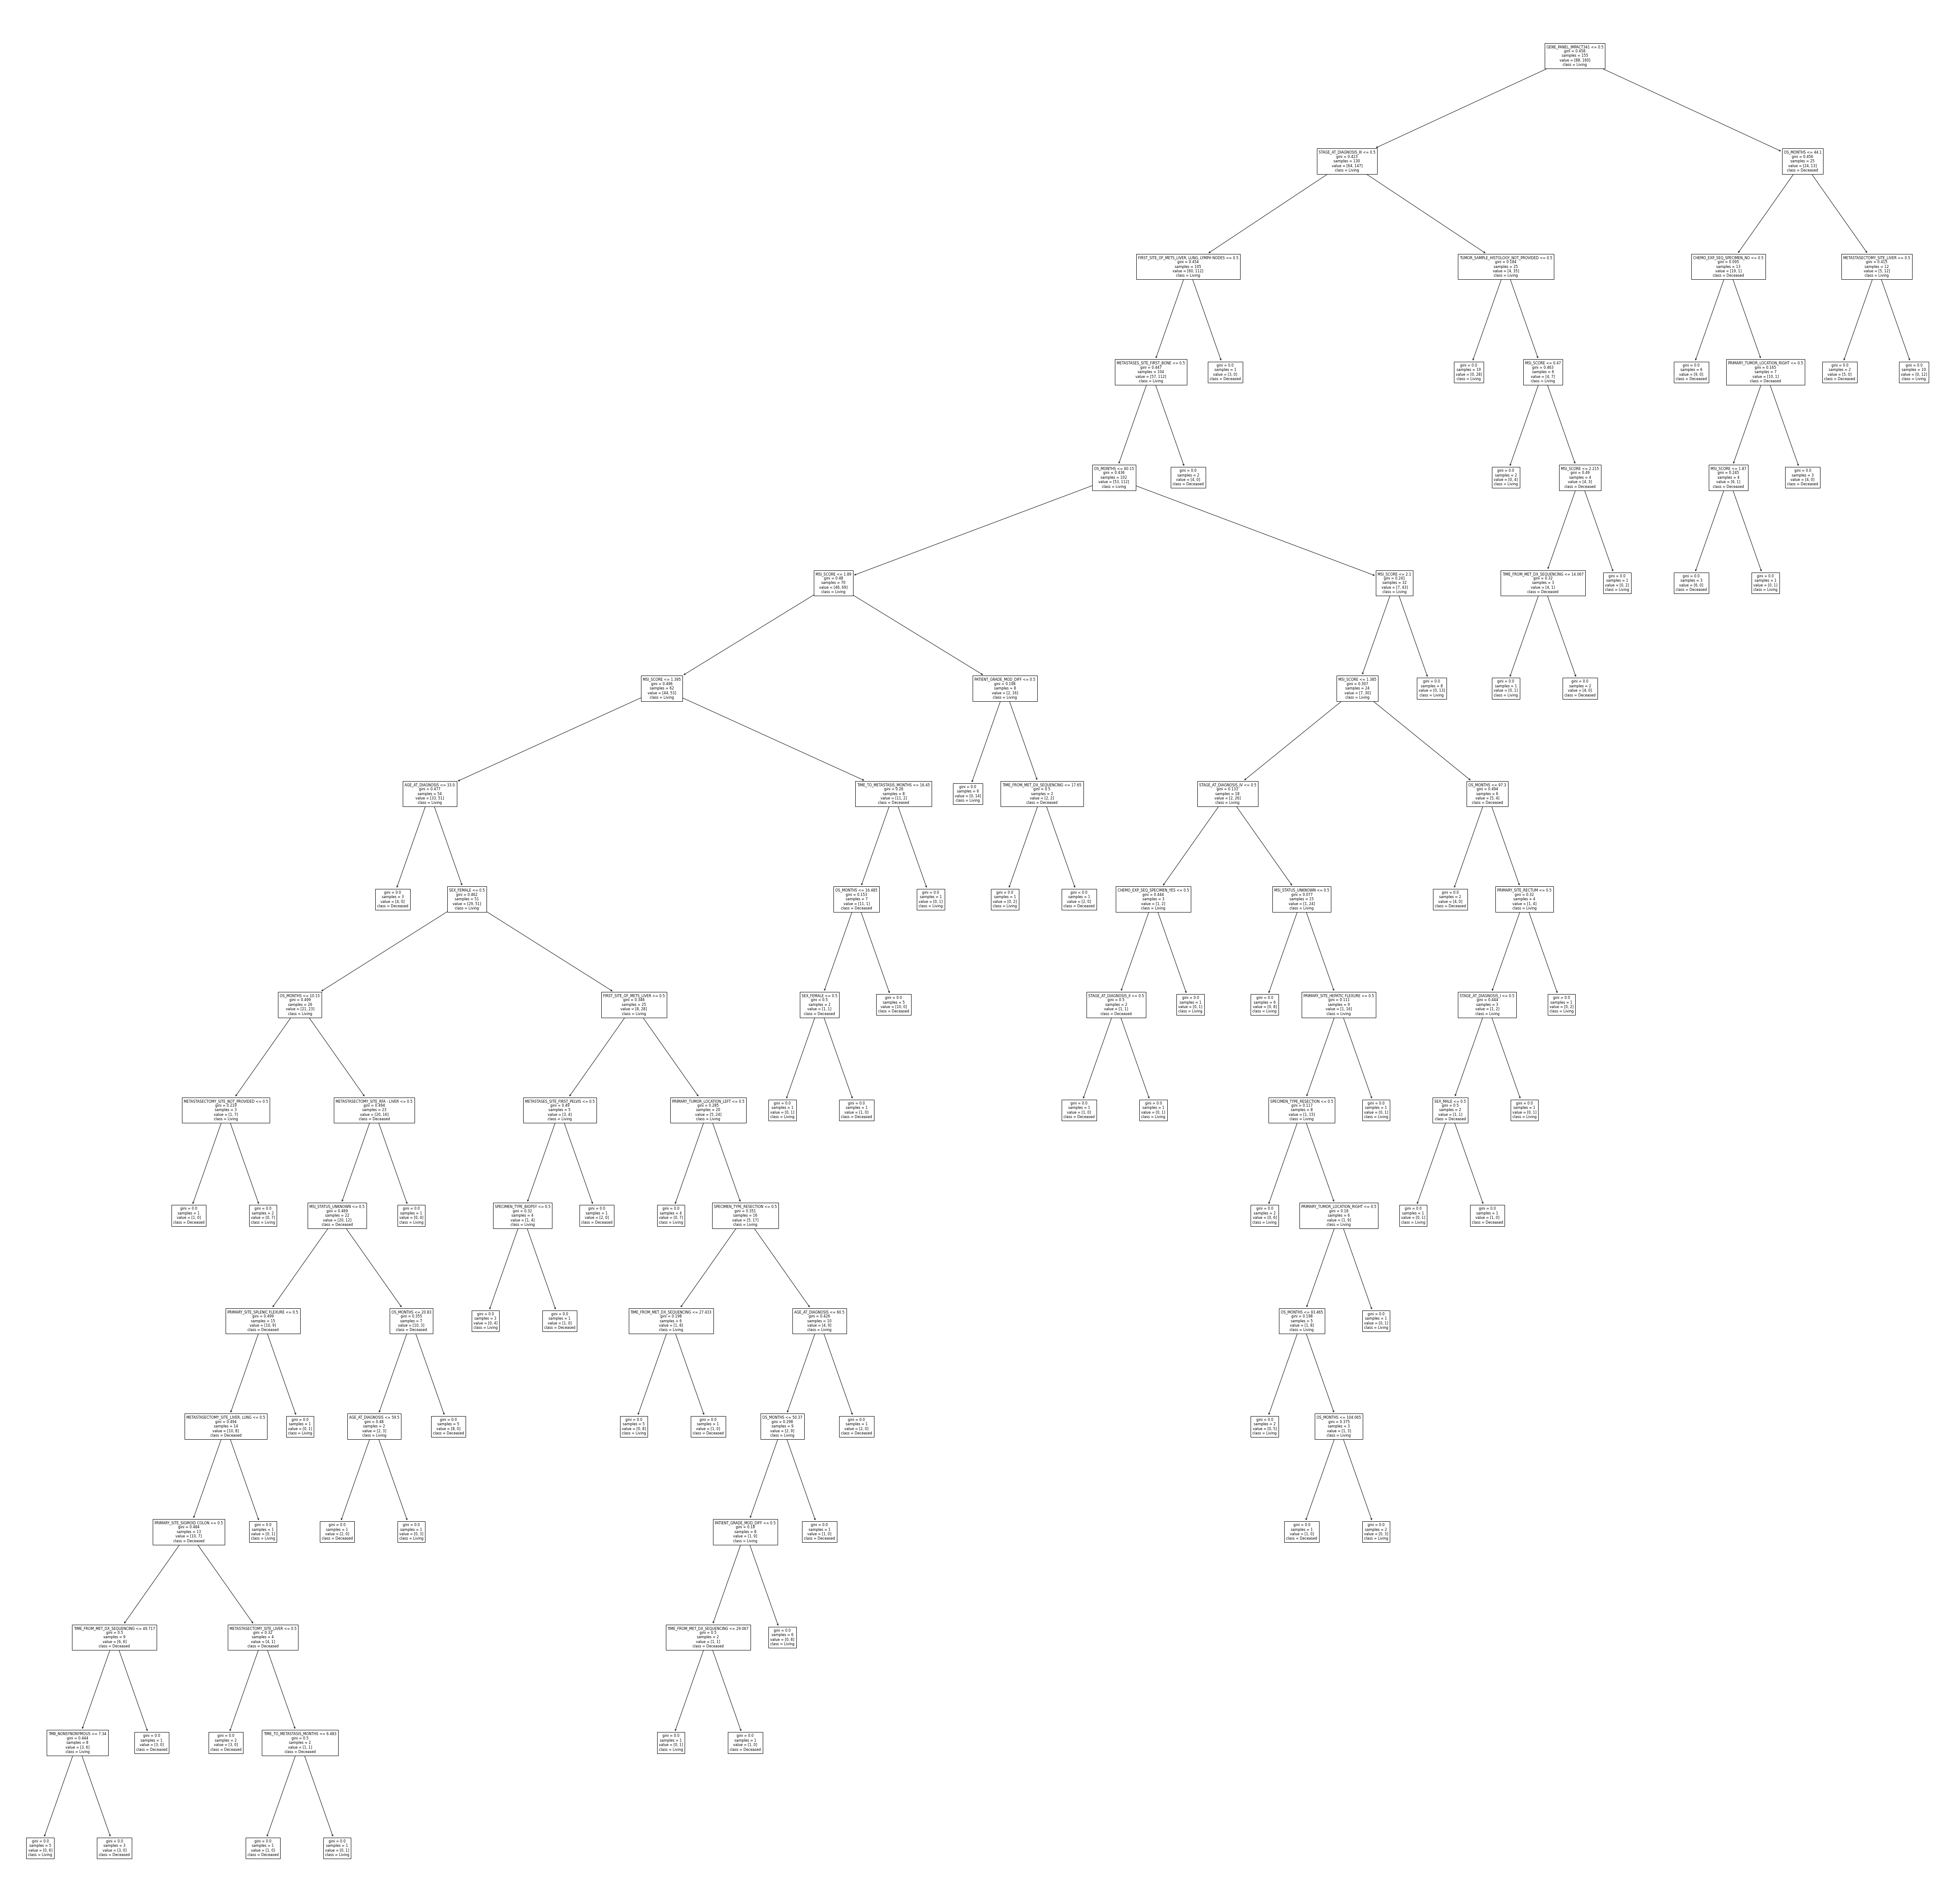

In [60]:
from sklearn import tree
plt.figure(figsize=(80,80))  # set plot size (denoted in inches)
#tree.plot_tree(clf.estimators_[0], fontsize=8)
#print(X_train2.columns)
tree.plot_tree(clf.estimators_[0], feature_names=X_train2.columns, class_names=y_train2.unique(), fontsize=8)
#tree.plot_tree(clf.estimators_[0], feature_names=X_train2.columns, class_names=True, fontsize=8)
plt.show()

In [59]:
rfr2 = RandomForestRegressor()
rfr2.fit(X_train2, y_train2)

y_pred2 = rfr2.predict(X_test2)

ValueError: could not convert string to float: 'Deceased'

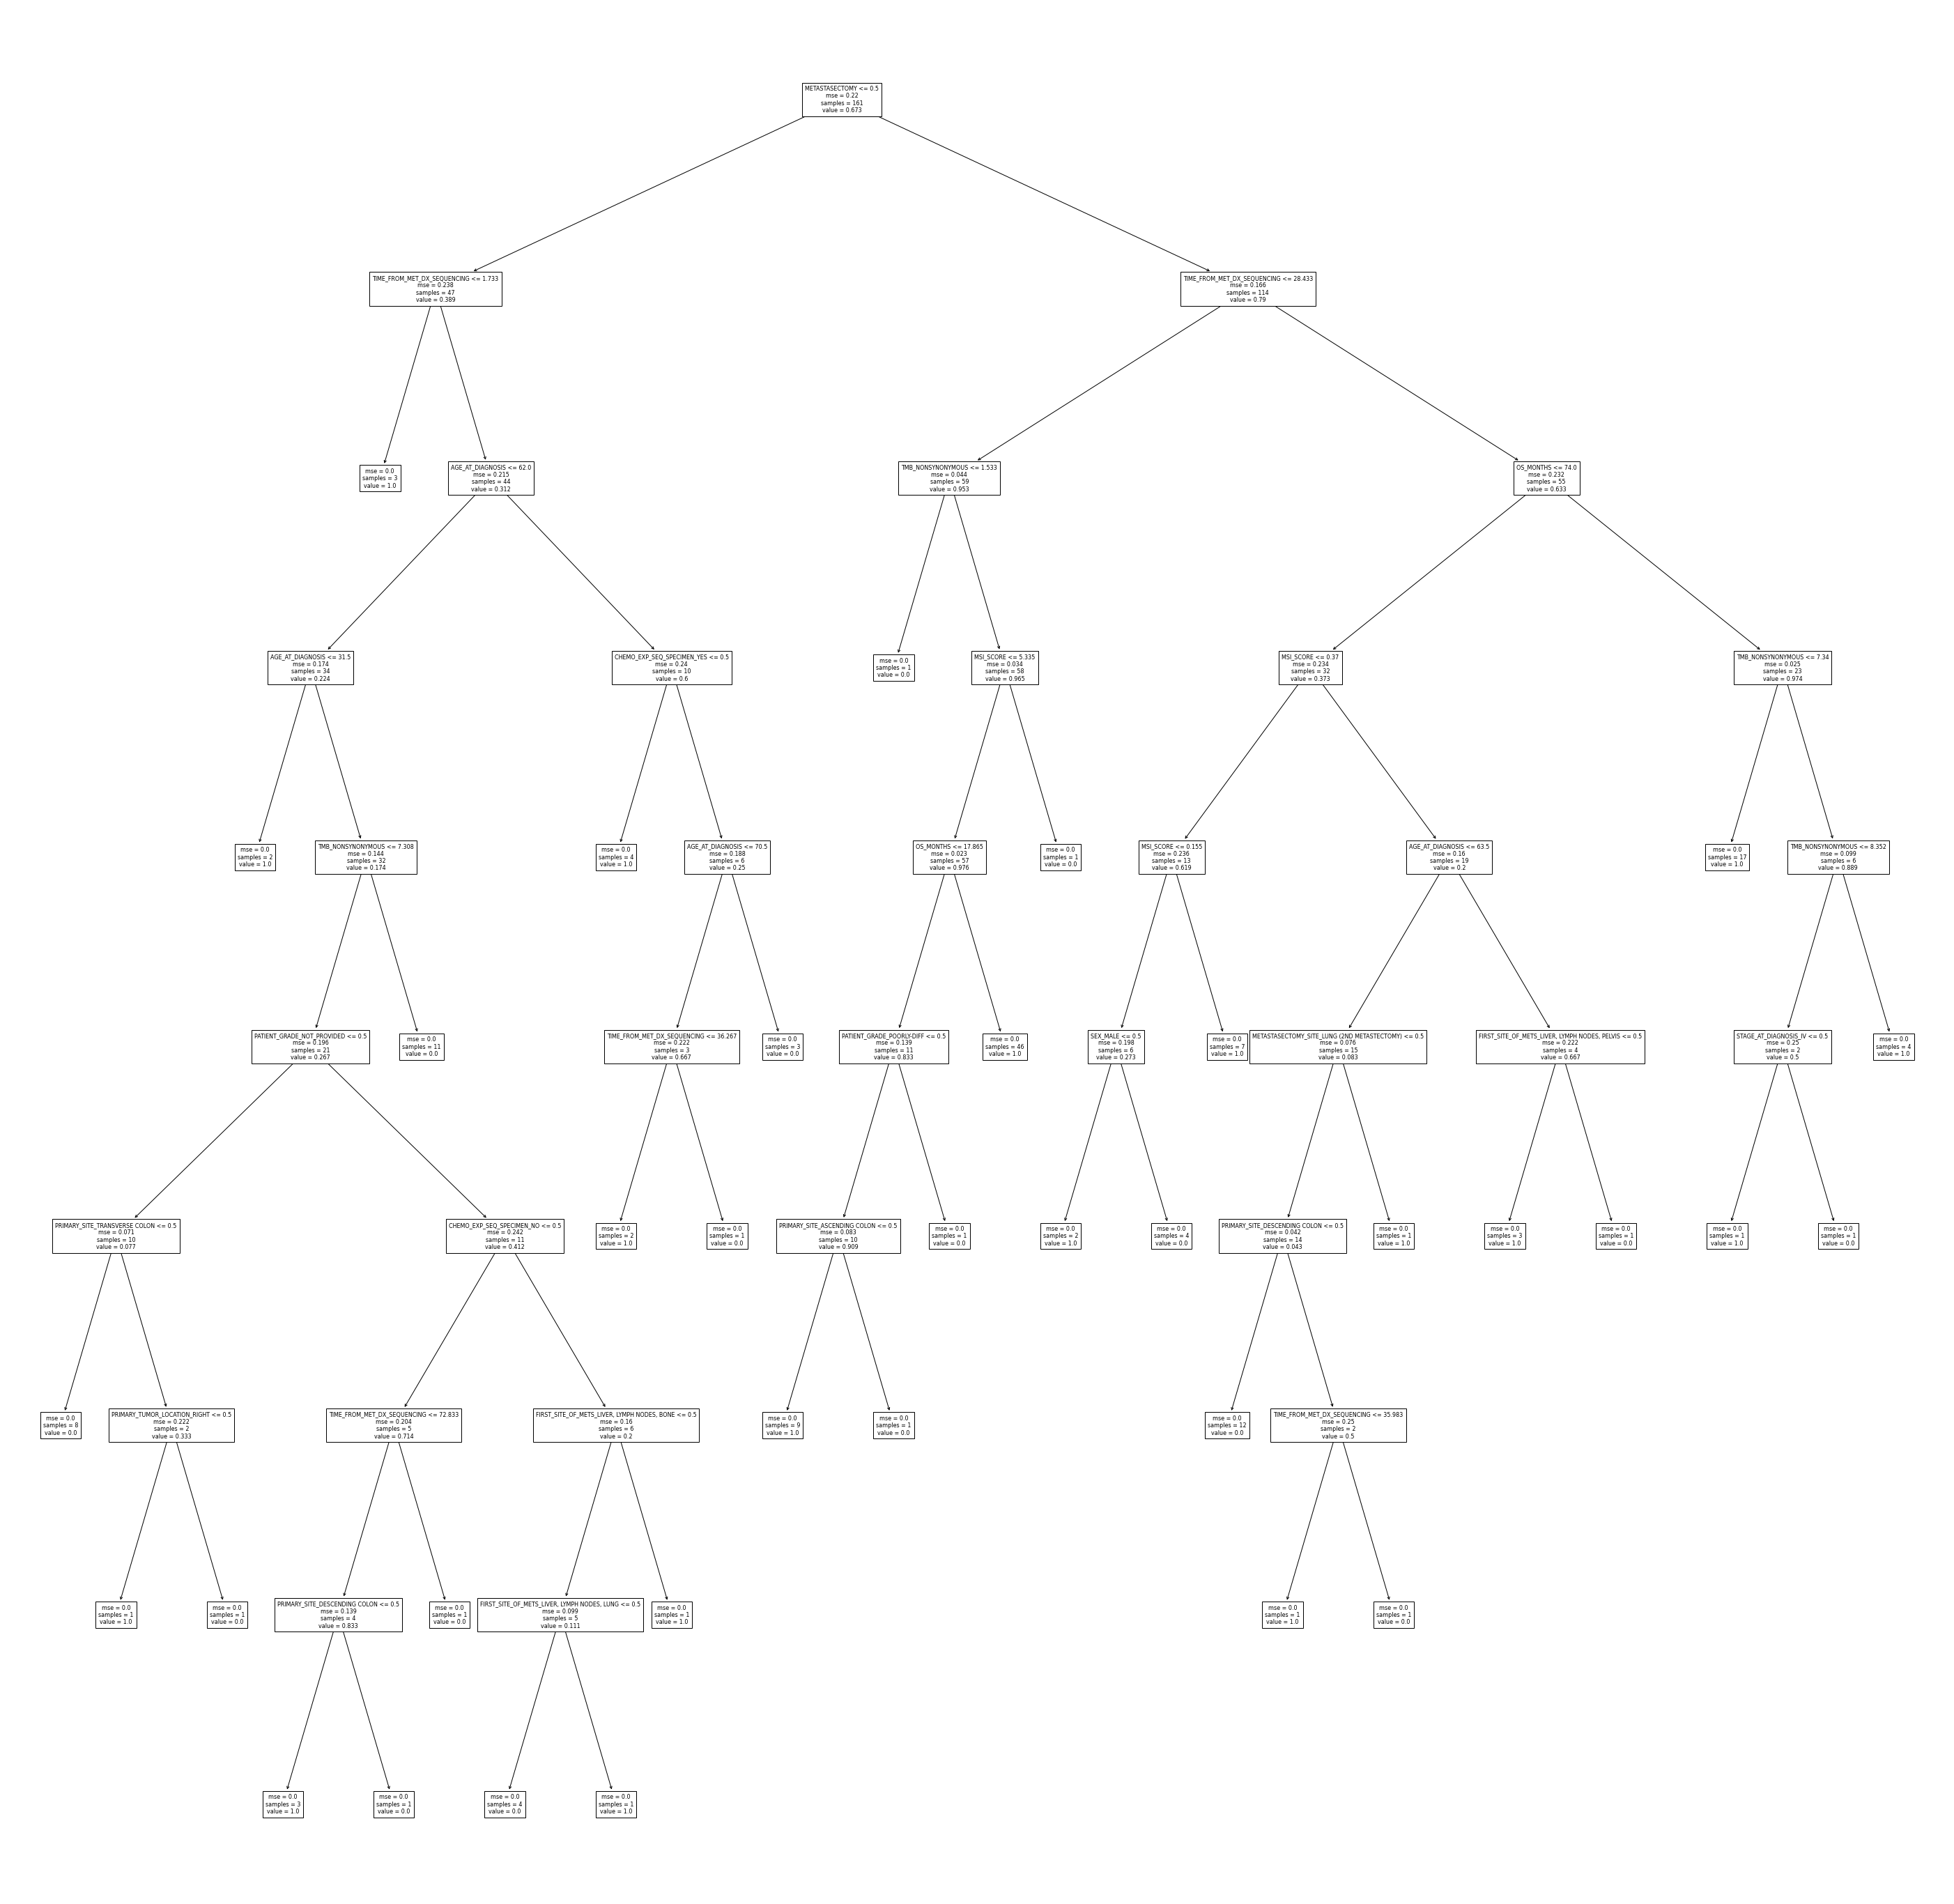

In [36]:
from sklearn import tree
plt.figure(figsize=(50,50))  # set plot size (denoted in inches)
tree.plot_tree(rfr2.estimators_[0], feature_names=X_train2.columns, fontsize=8)
plt.show()

### Neural Networks Models

In [52]:
from sklearn.datasets import load_iris
from sklearn import tree

iris = load_iris()
print(type(iris.target_names))

print(y_train2.unique())
print(type(y_train2.unique()))


<class 'numpy.ndarray'>
['Deceased' 'Living']
<class 'numpy.ndarray'>


In [55]:
iris.data


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [49]:
pandasSingleRow = X_test2.iloc[0]
singleRow = array(pandasSingleRow)

In [50]:
singleRow

array([66.        , 19.03      ,  0.89      ,  0.        ,  0.        ,
       17.2       ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        5.87231819,  1.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  1.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [33]:
X_train2.shape

(248, 101)

In [52]:
from numpy import exp, array, random, dot


class NeuralNetwork():
    def __init__(self):
        # Seed the random number generator, so it generates the same numbers
        # every time the program runs.
        random.seed(1)

        # We model a single neuron, with 3 input connections and 1 output connection.
        # We assign random weights to a 3 x 1 matrix, with values in the range -1 to 1
        # and mean 0.
        self.synaptic_weights = 2 * random.random((101, 1)) - 1

    # The Sigmoid function, which describes an S shaped curve.
    # We pass the weighted sum of the inputs through this function to
    # normalise them between 0 and 1.
    def __sigmoid(self, x):
        return 1 / (1 + exp(-x))

    # The derivative of the Sigmoid function.
    # This is the gradient of the Sigmoid curve.
    # It indicates how confident we are about the existing weight.
    def __sigmoid_derivative(self, x):
        return x * (1 - x)

    # We train the neural network through a process of trial and error.
    # Adjusting the synaptic weights each time.
    def train(self, training_set_inputs, training_set_outputs, number_of_training_iterations):
        for iteration in range(number_of_training_iterations):
            # Pass the training set through our neural network (a single neuron).
            output = self.think(training_set_inputs)

            # Calculate the error (The difference between the desired output
            # and the predicted output).
            error = training_set_outputs - output

            # Multiply the error by the input and again by the gradient of the Sigmoid curve.
            # This means less confident weights are adjusted more.
            # This means inputs, which are zero, do not cause changes to the weights.
            adjustment = dot(training_set_inputs.T, error * self.__sigmoid_derivative(output))

            # Adjust the weights.
            self.synaptic_weights = self.synaptic_weights + adjustment

    # The neural network thinks.
    def think(self, inputs):
        # Pass inputs through our neural network (our single neuron).
        return self.__sigmoid(dot(inputs, self.synaptic_weights))


#Intialise a single neuron neural network.
neural_network = NeuralNetwork()

print("Random starting synaptic weights: ")
print(neural_network.synaptic_weights)

# The training set. We have 4 examples, each consisting of 3 input values
# and 1 output value.
training_set_inputs = array(X_train2)
training_set_outputs = array([y_train2]).T

# Train the neural network using a training set.
# Do it 10,000 times and make small adjustments each time.
neural_network.train(training_set_inputs, training_set_outputs, 10000)

print ("New synaptic weights after training: ")
print (neural_network.synaptic_weights)
# Try to see what this does
    # Incorporate the XPandas Train set, turn it into an array, and update the 
    # synaptic weights after training to show the column values that are relevant
    # towards the model and which are not relevant towards the model


# Test the neural network with a new situation.
print("Considering new situation: ")
print(neural_network.think(singleRow))

Random starting synaptic weights: 
[[-0.16595599]
 [ 0.44064899]
 [-0.99977125]
 [-0.39533485]
 [-0.70648822]
 [-0.81532281]
 [-0.62747958]
 [-0.30887855]
 [-0.20646505]
 [ 0.07763347]
 [-0.16161097]
 [ 0.370439  ]
 [-0.5910955 ]
 [ 0.75623487]
 [-0.94522481]
 [ 0.34093502]
 [-0.1653904 ]
 [ 0.11737966]
 [-0.71922612]
 [-0.60379702]
 [ 0.60148914]
 [ 0.93652315]
 [-0.37315164]
 [ 0.38464523]
 [ 0.7527783 ]
 [ 0.78921333]
 [-0.82991158]
 [-0.92189043]
 [-0.66033916]
 [ 0.75628501]
 [-0.80330633]
 [-0.15778475]
 [ 0.91577906]
 [ 0.06633057]
 [ 0.38375423]
 [-0.36896874]
 [ 0.37300186]
 [ 0.66925134]
 [-0.96342345]
 [ 0.50028863]
 [ 0.97772218]
 [ 0.49633131]
 [-0.43911202]
 [ 0.57855866]
 [-0.79354799]
 [-0.10421295]
 [ 0.81719101]
 [-0.4127717 ]
 [-0.42444932]
 [-0.73994286]
 [-0.96126608]
 [ 0.35767107]
 [-0.57674377]
 [-0.46890668]
 [-0.01685368]
 [-0.89327491]
 [ 0.14823521]
 [-0.70654285]
 [ 0.17861107]
 [ 0.39951672]
 [-0.79533114]
 [-0.17188802]
 [ 0.38880032]
 [-0.17164146]
 [-0.

In [54]:
y_test2.iloc[0]

1